In [1]:
# MC Control, SARSA, Q-Learning, Double Q-learning

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q, 
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret
            
            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)
            
            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100, 
                        np.mean(episode_reward), 
                        np.mean(episode_regret)))
    return results

In [9]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [10]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v*({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [12]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

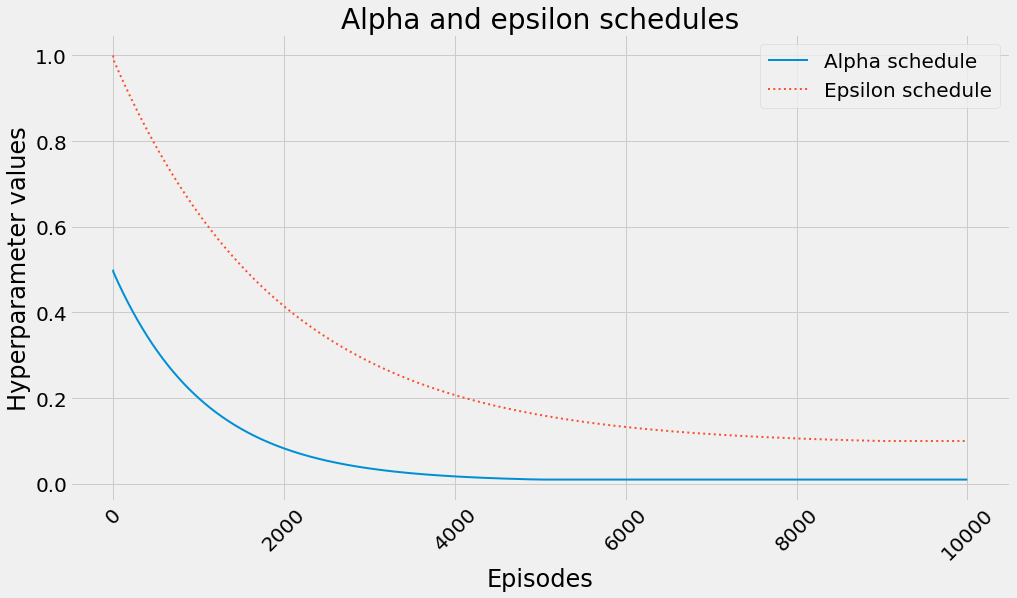

In [13]:
plt.plot([decay_schedule(0.5, 0.01, 0.5, 10000, i) for i in range(10000)], 
         '-', linewidth=2, 
         label='Alpha schedule')
plt.plot([decay_schedule(1.0, 0.1, 0.9, 10000, i) for i in range(10000)], 
         ':', linewidth=2, 
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [14]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤════════╤════════╕
│   s │      < │      > │
╞═════╪════════╪════════╡
│   0 │ 0      │ 0      │
├─────┼────────┼────────┤
│   1 │ 0.3119 │ 0.5637 │
├─────┼────────┼────────┤
│   2 │ 0.6703 │ 0.763  │
├─────┼────────┼────────┤
│   3 │ 0.8032 │ 0.8449 │
├─────┼────────┼────────┤
│   4 │ 0.8638 │ 0.8892 │
├─────┼────────┼────────┤
│   5 │ 0.9014 │ 0.922  │
├─────┼────────┼────────┤
│   6 │ 0.9322 │ 0.9515 │
├─────┼────────┼────────┤
│   7 │ 0.9613 │ 0.9806 │
├─────┼────────┼────────┤
│   8 │ 0      │ 0      │
╘═════╧════════╧════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8548. Regret of 0.0000


# First-visit Monte-Carlo Control

In [15]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [16]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, 
                            max_steps, 
                            num=max_steps, 
                            base=gamma, 
                            endpoint=False)    
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(init_alpha, 
                               min_alpha, 
                               alpha_decay_ratio, 
                               n_episodes, 
                               e)
        epsilon = decay_schedule(init_epsilon, 
                                 min_epsilon, 
                                 epsilon_decay_ratio, 
                                 n_episodes, 
                                 e)  
        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilon,
                                         env, 
                                         max_steps)
        visited = np.zeros((nS, nA), dtype=np.bool)
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True
            
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [17]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [18]:
print_state_value_function(V_mc, P, n_cols=9, prec=4, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', '>'), n_cols=9)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
|           | 01 0.5065 | 02 0.7266 | 03 0.8218 | 04 0.8704 | 05 0.9078 | 06 0.9443 | 07 0.9774 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0573 | 02 -0.0364 | 03 -0.0231 | 04 -0.0188 | 05 -0.0142 | 06 -0.0073 | 07 -0.0032 |           |
State-value function RMSE: 0.0253

FVMC action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2    │ 0.5065 │ 0.3119 │ 0.5637 │  0.112  │  0.0573 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.5504 │ 0.7266 │ 0.6703 │ 0.763  │  0.1198 │  0.

# SARSA

In [19]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.5,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e)   
        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state, action = next_state, next_action
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [20]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [21]:
print_state_value_function(V_sarsa, P, n_cols=9, prec=4, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', '>'), n_cols=9)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by SARSA:
|           | 01 0.4546 | 02 0.6825 | 03 0.7906 | 04 0.8619 | 05 0.9064 | 06 0.9439 | 07 0.9787 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.1091 | 02 -0.0805 | 03 -0.0543 | 04 -0.0273 | 05 -0.0156 | 06 -0.0077 | 07 -0.0019 |           |
State-value function RMSE: 0.0499

SARSA action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.1751 │ 0.4546 │ 0.3119 │ 0.5637 │  0.1368 │  0.1091 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.5049 │ 0.6825 │ 0.6703 │ 0.763  │  0.1653 │  

# Q-Learning

In [22]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.5,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state = next_state

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [23]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [24]:
print_state_value_function(V_ql, P, n_cols=9, prec=4, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', '>'), n_cols=9)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
|           | 01 0.5687 | 02 0.7672 | 03 0.8475 | 04 0.8894 | 05 0.9213 | 06 0.9504 | 07 0.9802 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 0.0049 | 02 0.0042 | 03 0.0027 | 04 0.0001 | 05 -0.0006 | 06 -0.0011 | 07 -0.0004 |           |
State-value function RMSE: 0.0024

Q-learning action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2955 │ 0.5687 │ 0.3119 │ 0.5637 │  0.0165 │ -0.0049 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6621 │ 0.7672 │ 0.6703 │ 0.763  │  0.00

# Double Q-Learning

In [25]:
def double_q_learning(env,
                      gamma=1.0,
                      init_alpha=0.5,
                      min_alpha=0.01,
                      alpha_decay_ratio=0.5,
                      init_epsilon=1.0,
                      min_epsilon=0.1,
                      epsilon_decay_ratio=0.9,
                      n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q1 = np.zeros((nS, nA))
    Q2 = np.zeros((nS, nA))
    Q_track1 = np.zeros((n_episodes, nS, nA))
    Q_track2 = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q1 + Q2, epsilon)
            next_state, reward, done, _ = env.step(action)

            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_target - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alpha * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_target - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alpha * td_error
            state = next_state

        Q_track1[e] = Q1
        Q_track2[e] = Q2        
        pi_track.append(np.argmax(Q1 + Q2, axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, (Q_track1 + Q_track2)/2., pi_track

In [26]:
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [27]:
print_state_value_function(V_dql, P, n_cols=9, prec=4, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', '>'), n_cols=9)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
|           | 01 0.5631 | 02 0.7625 | 03  0.845 | 04 0.8888 | 05 0.9222 | 06 0.9519 | 07 0.9813 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0007 | 02 -0.0005 | 03 0.0001 | 04 -0.0004 | 05 0.0002 | 06 0.0003 | 07 0.0007 |           |
State-value function RMSE: 0.0004

Double Q-Learning action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2953 │ 0.5631 │ 0.3119 │ 0.5637 │  0.0166 │  0.0007 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6503 │ 0.7625 │ 0.6703 │ 

# Comparison of max(Q) for every episode

## First-visit Monte-Carlo

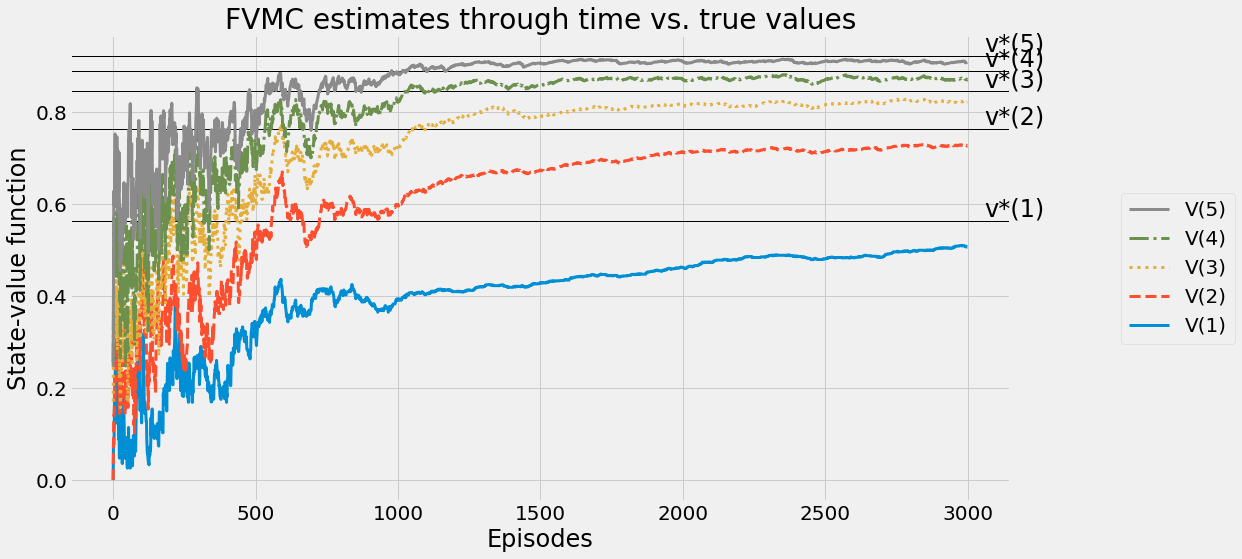

In [28]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

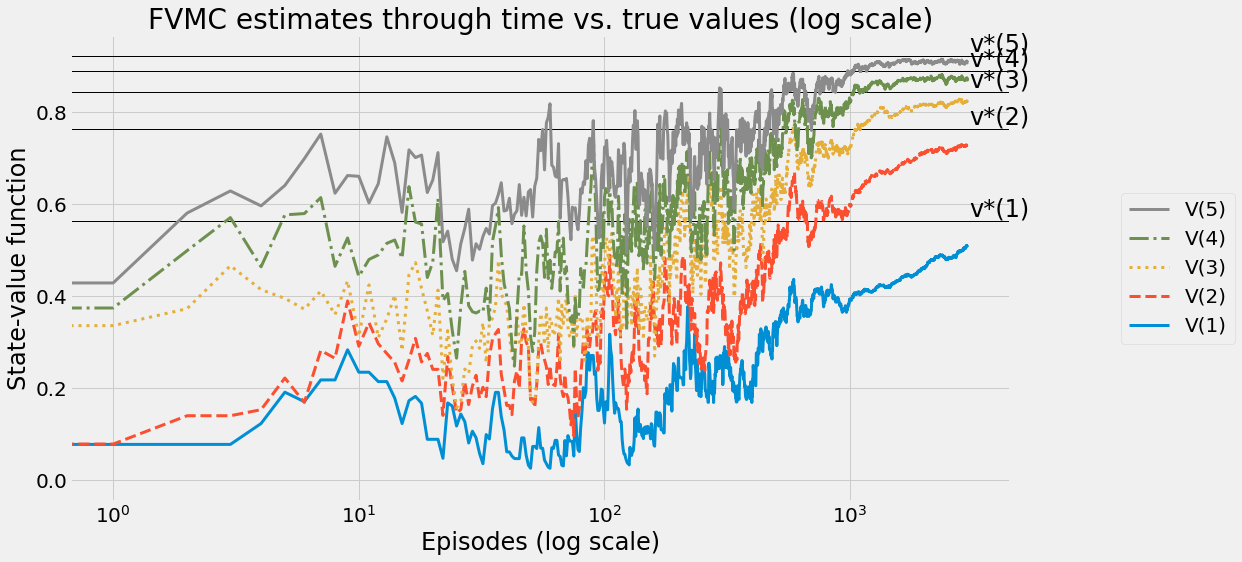

In [29]:
plot_value_function(
    'FVMC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

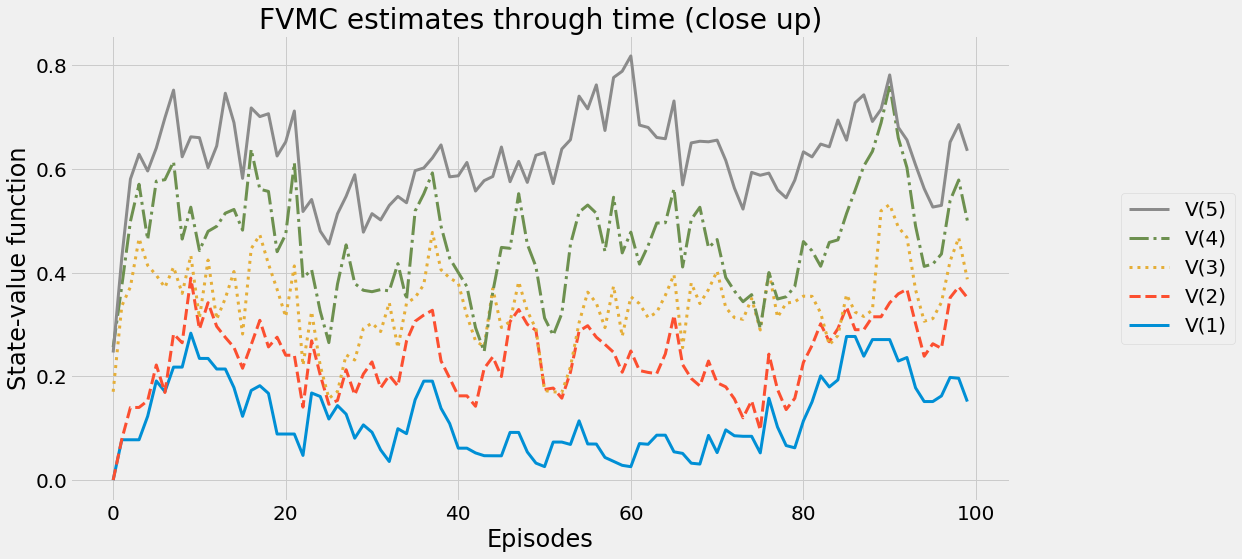

In [30]:
plot_value_function(
    'FVMC estimates through time (close up)', 
    np.max(Q_track_mc, axis=2)[:100], 
    None,
    log=False)

## SARSA

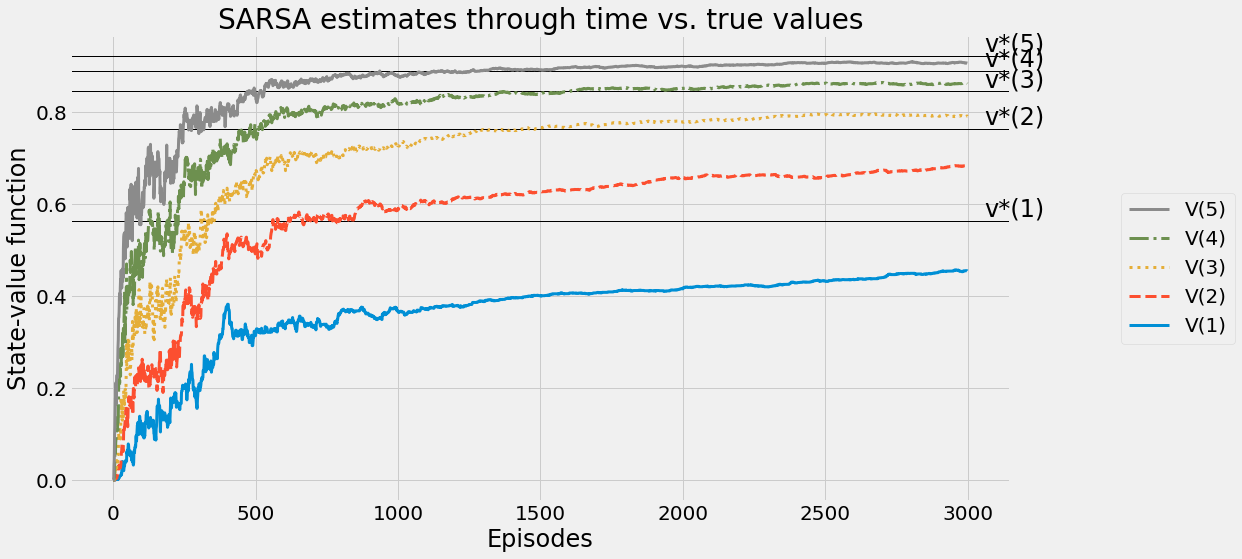

In [31]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

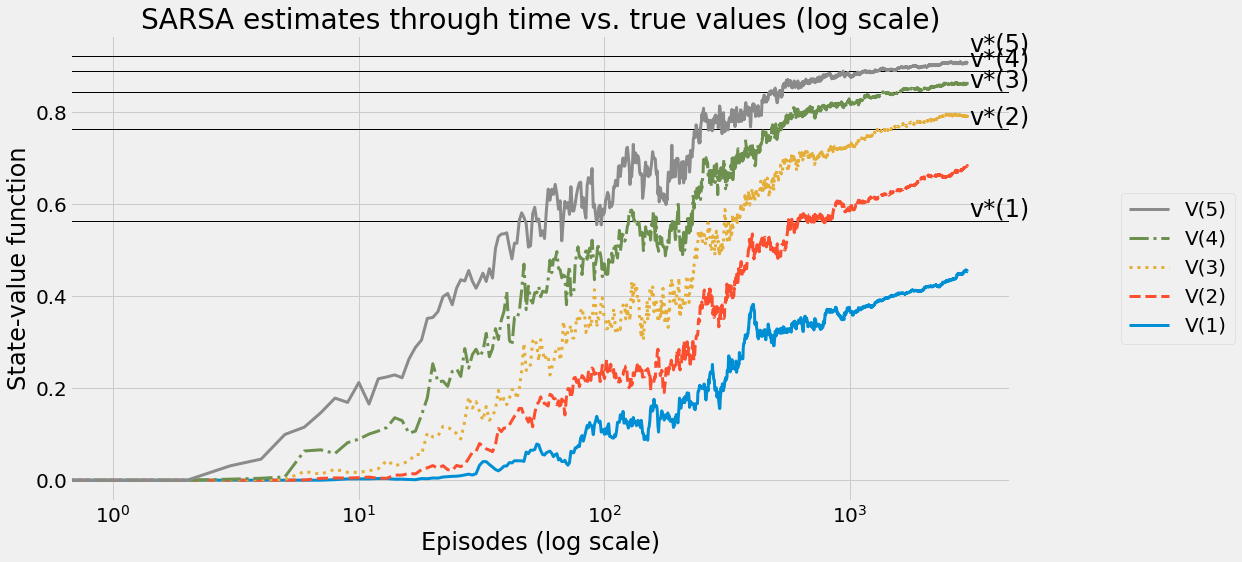

In [32]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

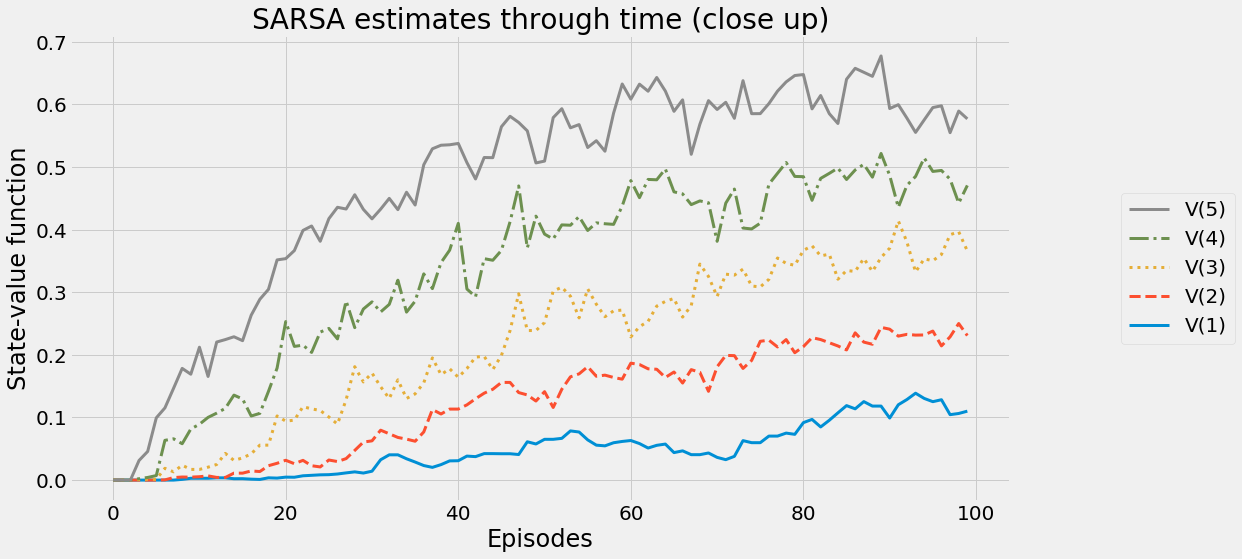

In [33]:
plot_value_function(
    'SARSA estimates through time (close up)', 
    np.max(Q_track_sarsa, axis=2)[:100], 
    None,
    log=False)

## Q-learning

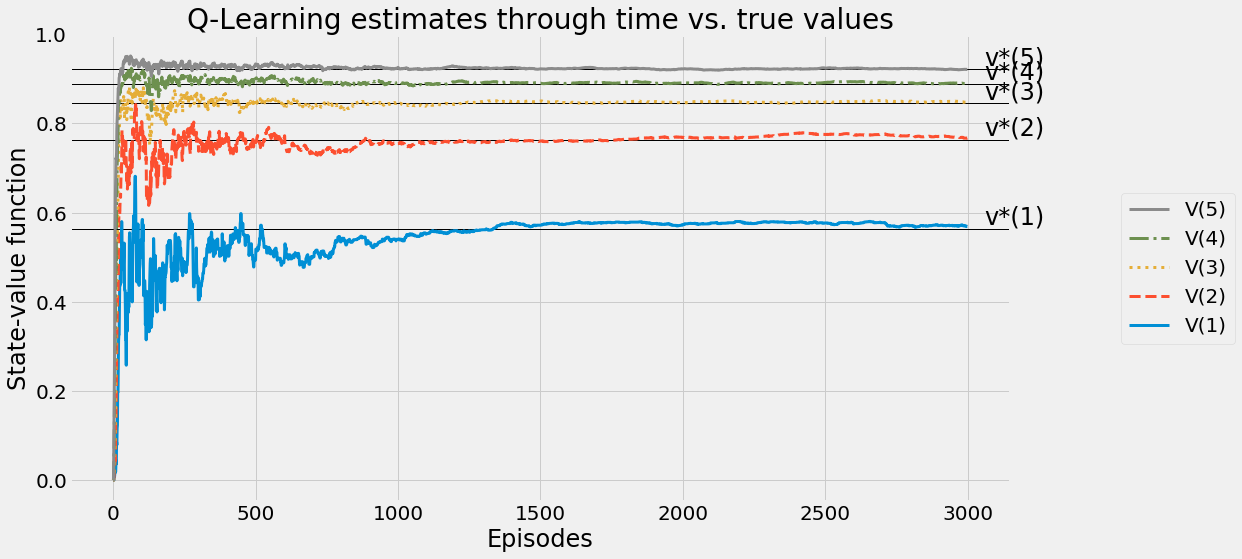

In [34]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

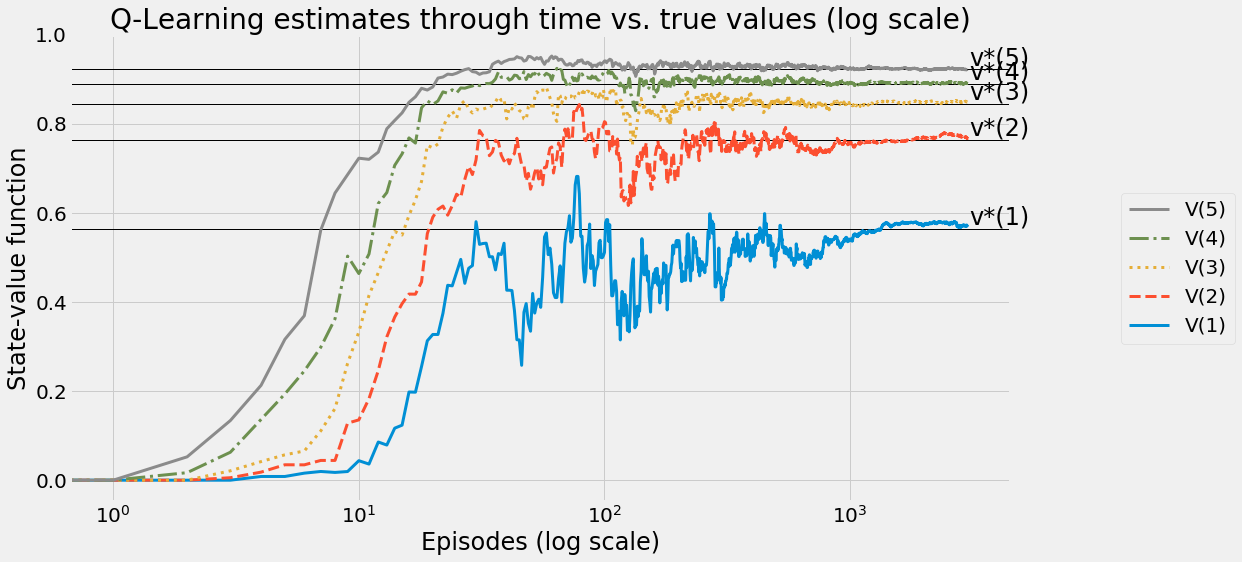

In [35]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

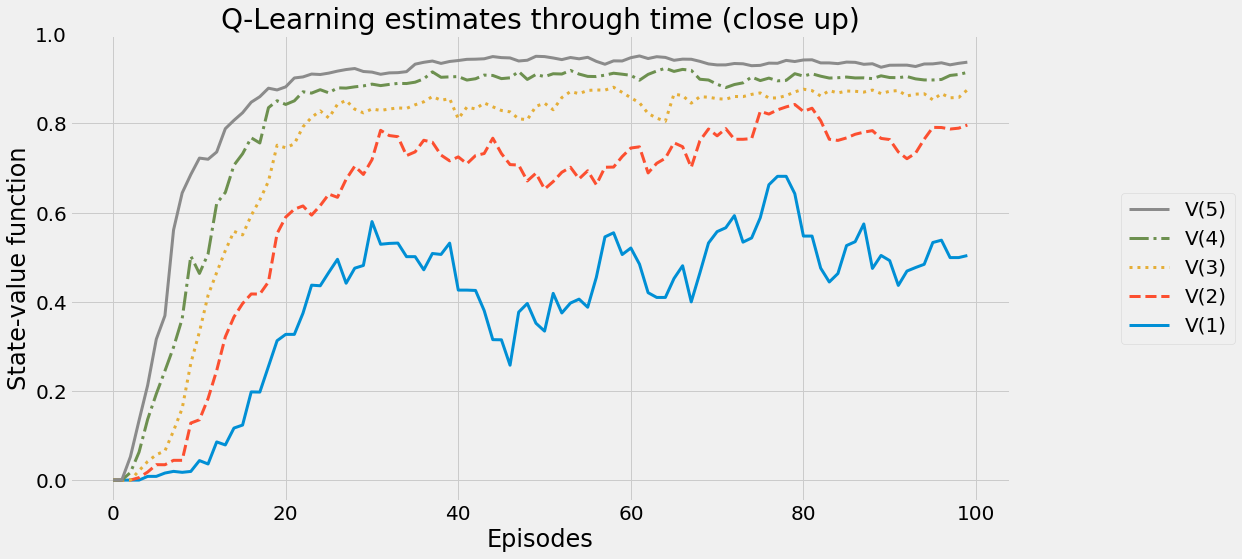

In [36]:
plot_value_function(
    'Q-Learning estimates through time (close up)', 
    np.max(Q_track_ql, axis=2)[:100], 
    None,
    log=False)

## Double Q-Learning

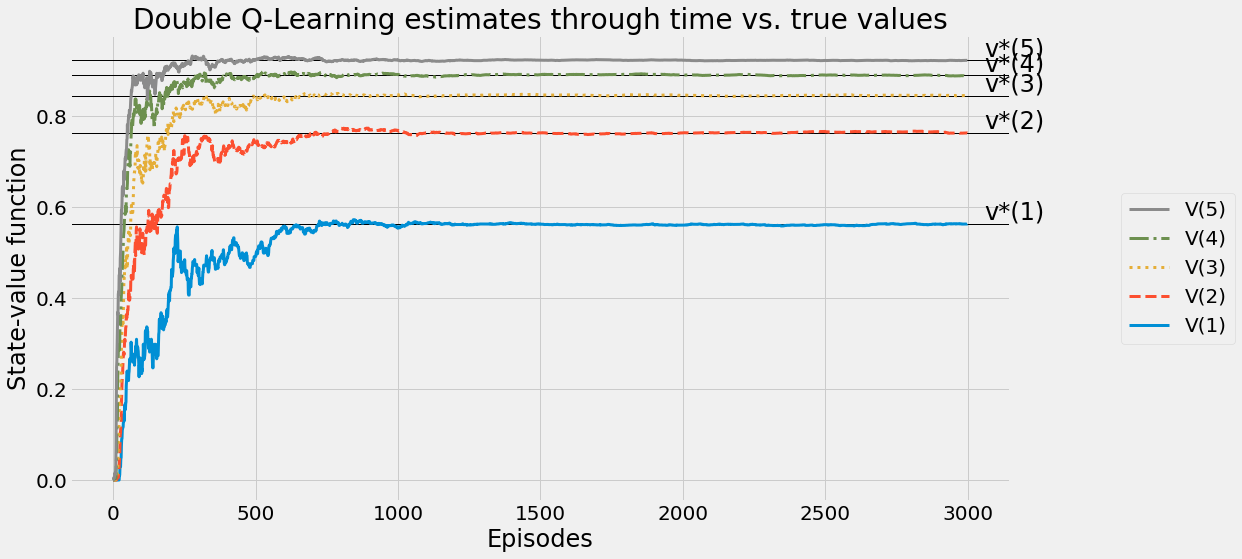

In [37]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=5,
    log=False)

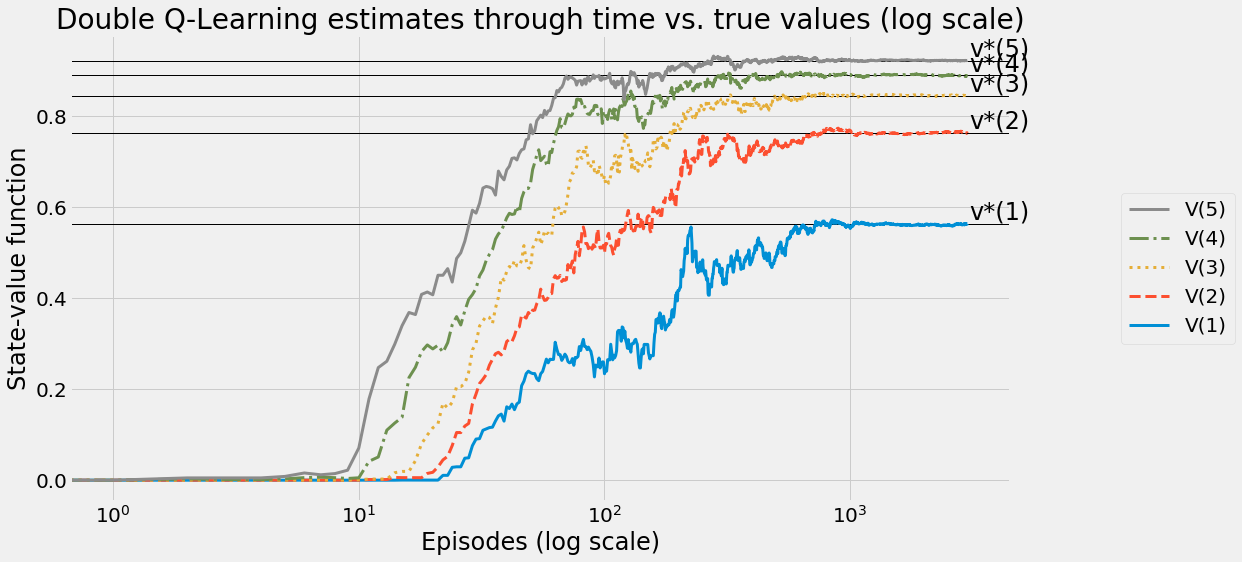

In [38]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

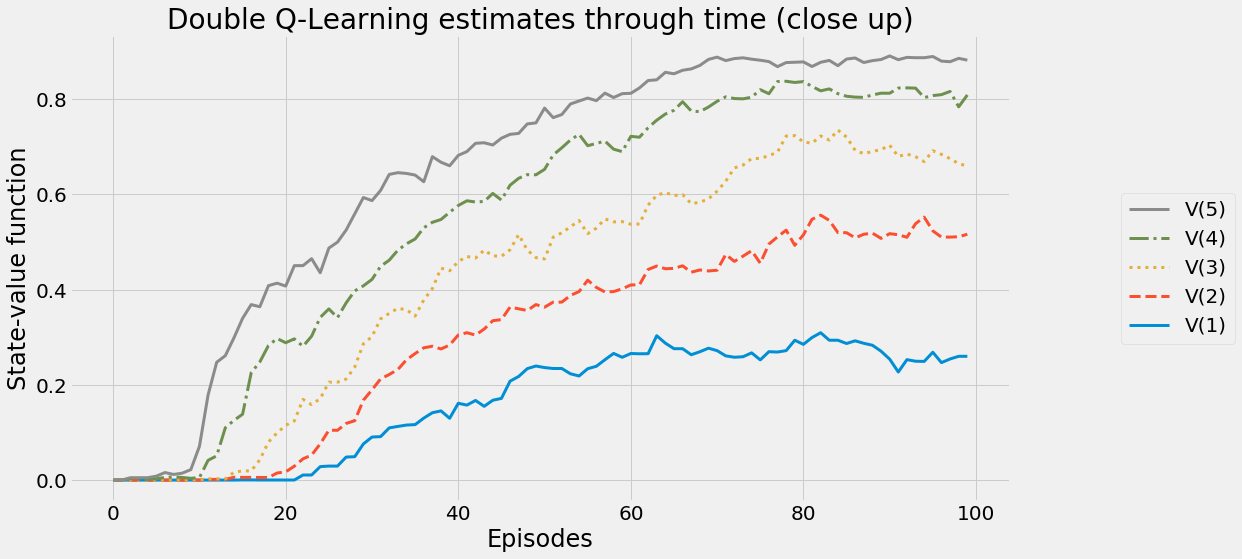

In [39]:
plot_value_function(
    'Double Q-Learning estimates through time (close up)', 
    np.max(Q_track_dql, axis=2)[:100], 
    None,
    log=False)

# Policy evolution comparison

In [40]:
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_mc)])).T

In [41]:
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma,
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_sarsa)])).T

In [42]:
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma,
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_ql)])).T

In [43]:
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma,
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_dql)])).T

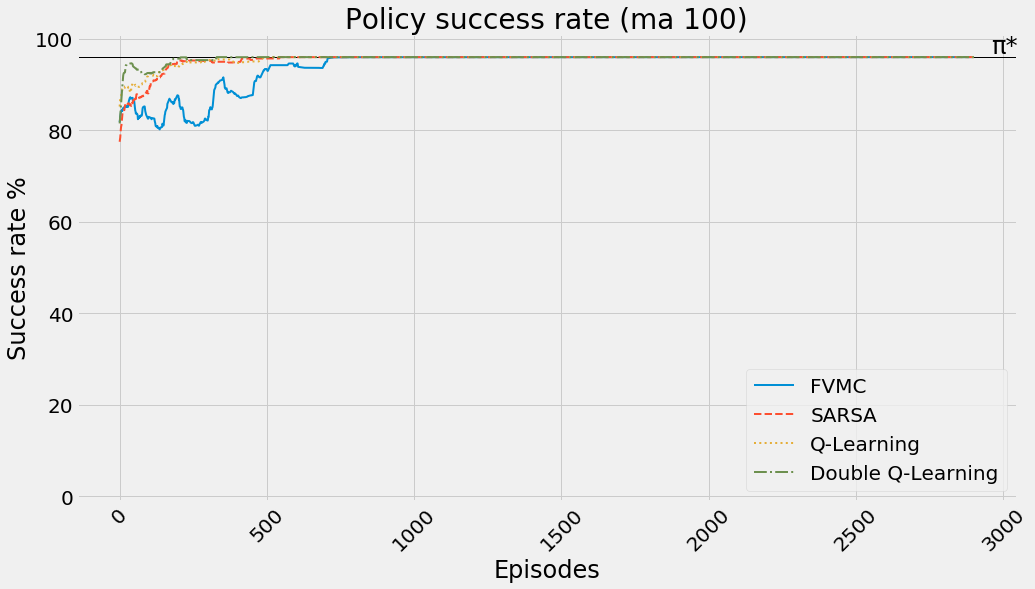

In [44]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

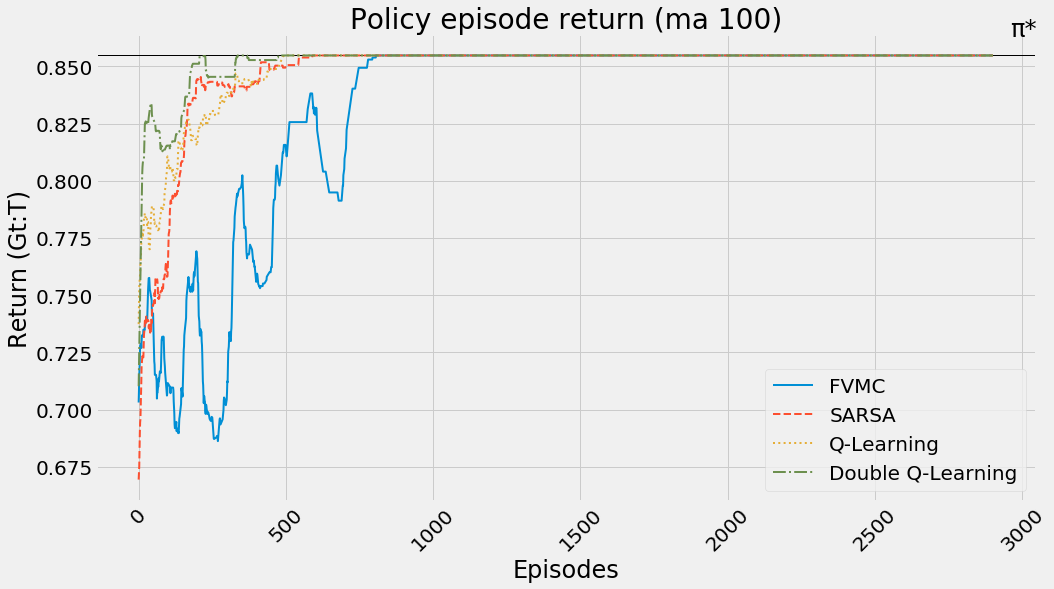

In [45]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

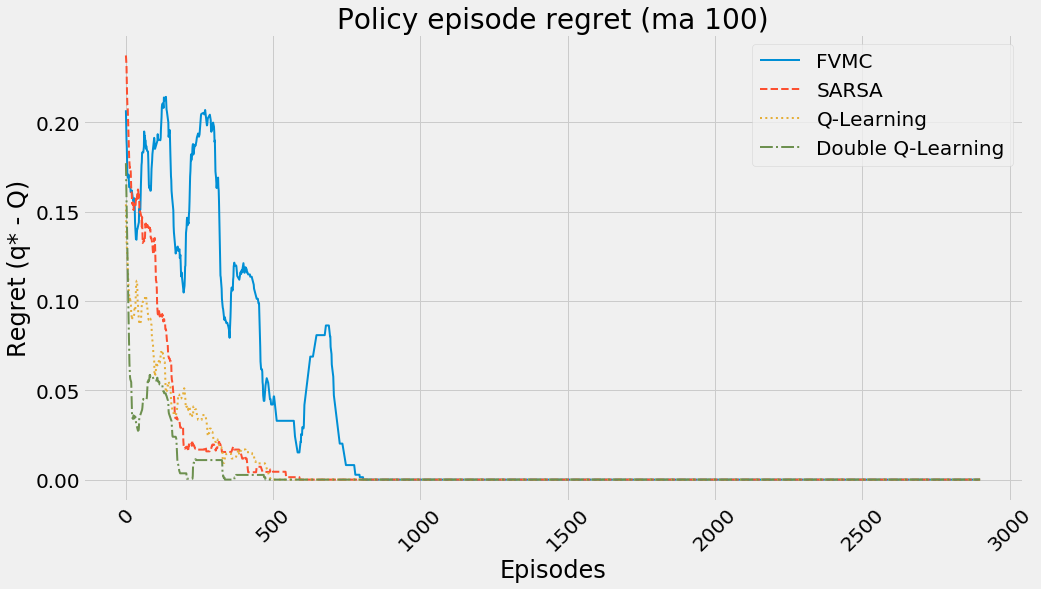

In [46]:
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

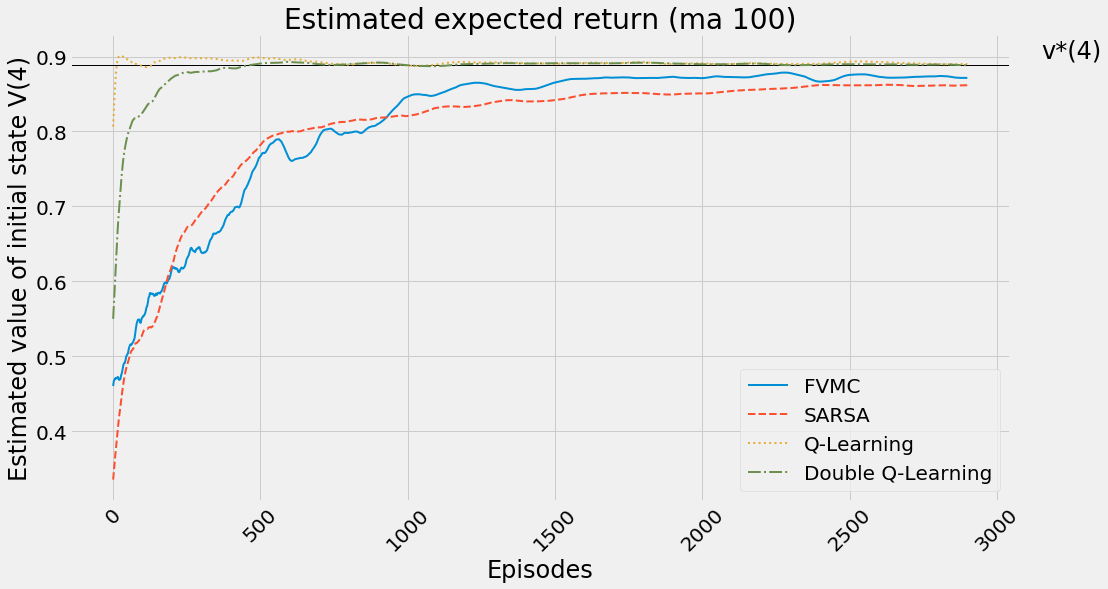

In [47]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

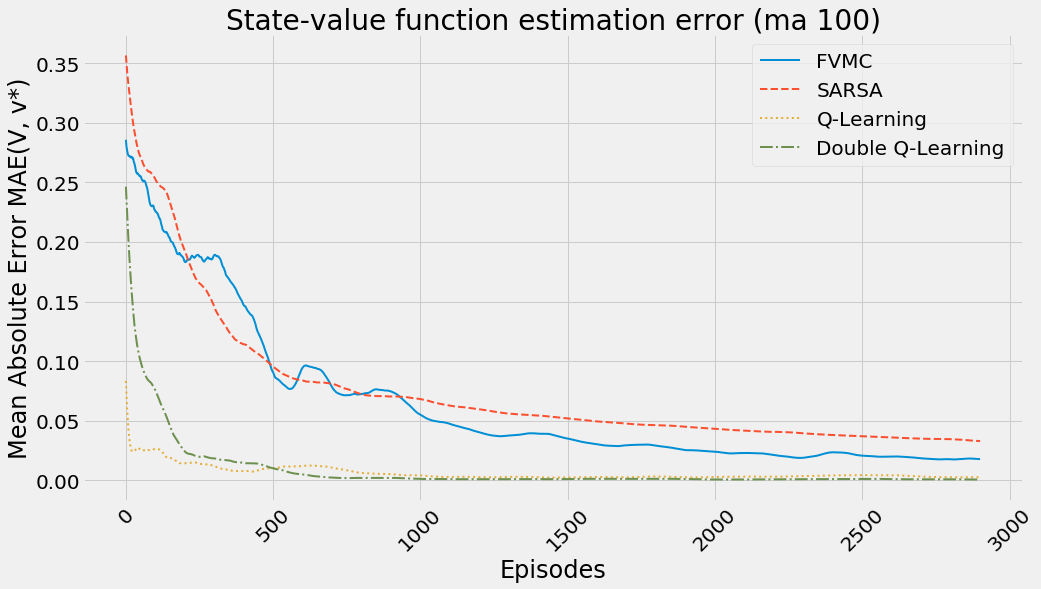

In [48]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

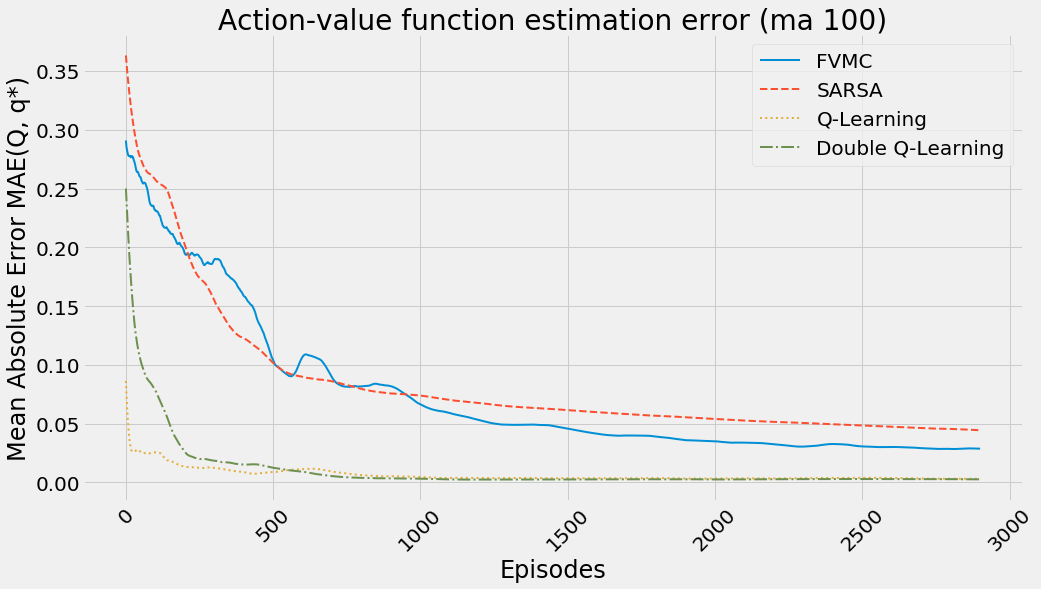

In [49]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()

# Russell & Norvig's Gridworld

In [50]:
env = gym.make('RussellNorvigGridworld-v0')
init_state = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 4000
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |

Optimal action-value function:
╒═════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      v │       > │       ^ │
╞═════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0.7666 │ 0.7372 │  0.8116 │  0.7772 │
├─────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.7828 │ 0.8272 │  0.8678 │  0.8272 │
├─────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.8121 │ 0.675  │  0.9178 │  0.881  │
├─────┼────────┼────────┼─────────┼─────────┤
│   3 │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼─────────┼─────────┤
│   4 │ 0.7209 │ 0.6766 │  0.7209 │  0.7616 │
├─────┼────────┼────────┼─────────┼─────────┤
│   5 │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼─────────┼─────────┤
│   6 │ 0.6411 │ 0.4152 │ -0.6871 │  0.6603 │
├─────┼────────┼────────┼─────────┼─────────┤
│   7 

In [51]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [52]:
print_state_value_function(V_mc, P, n_cols=4, prec=3, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
| 00   0.79 | 01  0.854 | 02  0.914 |           |
| 04  0.734 |           | 06  0.619 |           |
| 08  0.648 | 09  0.475 | 10  0.422 | 11 -0.067 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00 -0.021 | 01 -0.014 | 02 -0.003 |           |
| 04 -0.027 |           | 06 -0.041 |           |
| 08 -0.058 | 09  -0.18 | 10  -0.19 | 11 -0.455 |
State-value function RMSE: 0.1532

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.56 │  0.57 │  0.79 │  0.58 │  0.77 │  0.74 │ 

In [53]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [54]:
print_state_value_function(V_sarsa, P, n_cols=4, prec=3, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by SARSA:
| 00  0.762 | 01  0.832 | 02  0.911 |           |
| 04  0.697 |           | 06  0.608 |           |
| 08  0.614 | 09  0.535 | 10  0.221 | 11 -0.333 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00  -0.05 | 01 -0.036 | 02 -0.007 |           |
| 04 -0.065 |           | 06 -0.052 |           |
| 08 -0.091 | 09  -0.12 | 10  -0.39 | 11 -0.721 |
State-value function RMSE: 0.2424

SARSA action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.65 │  0.61 │  0.76 │  0.66 │  0.77 │  0.74 

In [55]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [56]:
print_state_value_function(V_ql, P, n_cols=4, prec=3, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
| 00  0.819 | 01   0.87 | 02  0.916 |           |
| 04  0.766 |           | 06  0.653 |           |
| 08  0.707 | 09  0.653 | 10  0.609 | 11  0.398 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00  0.008 | 01  0.002 | 02 -0.002 |           |
| 04  0.004 |           | 06 -0.007 |           |
| 08  0.001 | 09 -0.002 | 10 -0.002 | 11   0.01 |
State-value function RMSE: 0.0045

Q-learning action-value function:
╒═════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.77 │ 0.74 │  0.82 │  0.78 │  0.77 │  0.7

In [57]:
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [58]:
print_state_value_function(V_dql, P, n_cols=4, prec=3, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
| 00  0.813 | 01  0.871 | 02  0.922 |           |
| 04  0.762 |           | 06  0.674 |           |
| 08  0.706 | 09  0.654 | 10  0.595 | 11  0.354 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00  0.002 | 01  0.004 | 02  0.004 |           |
| 04  0.001 |           | 06  0.013 |           |
| 08    0.0 | 09 -0.002 | 10 -0.016 | 11 -0.034 |
State-value function RMSE: 0.0117

Double Q-Learning action-value function:
╒═════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.76 │ 0.74 │  0.81 │  0.77 

# Comparison of max(Q) for every episode

## Monte-Carlo

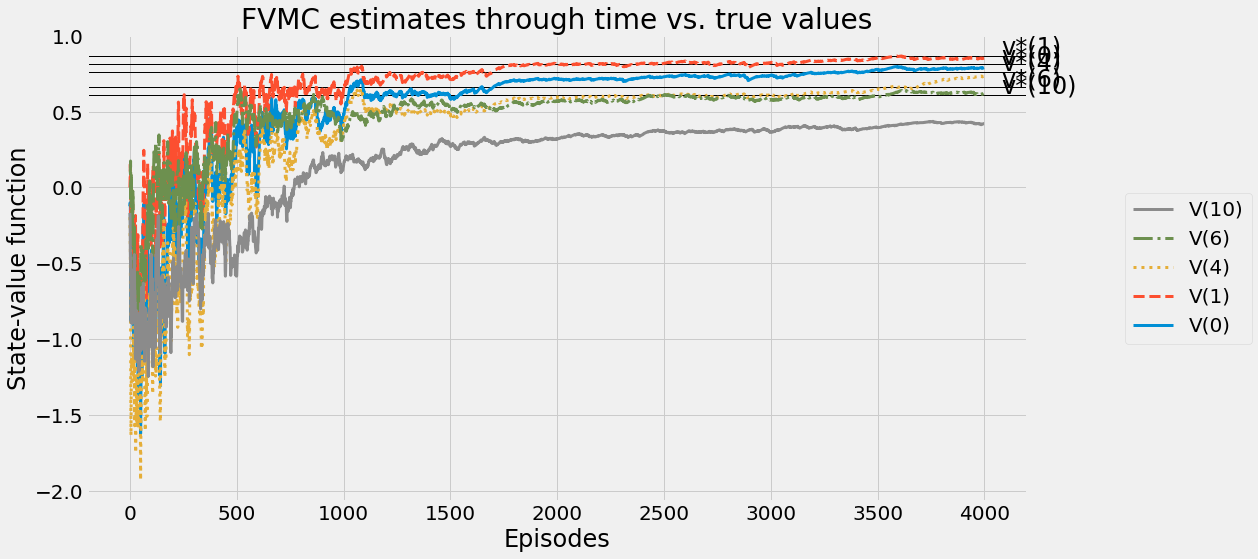

In [59]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.01,
    log=False)

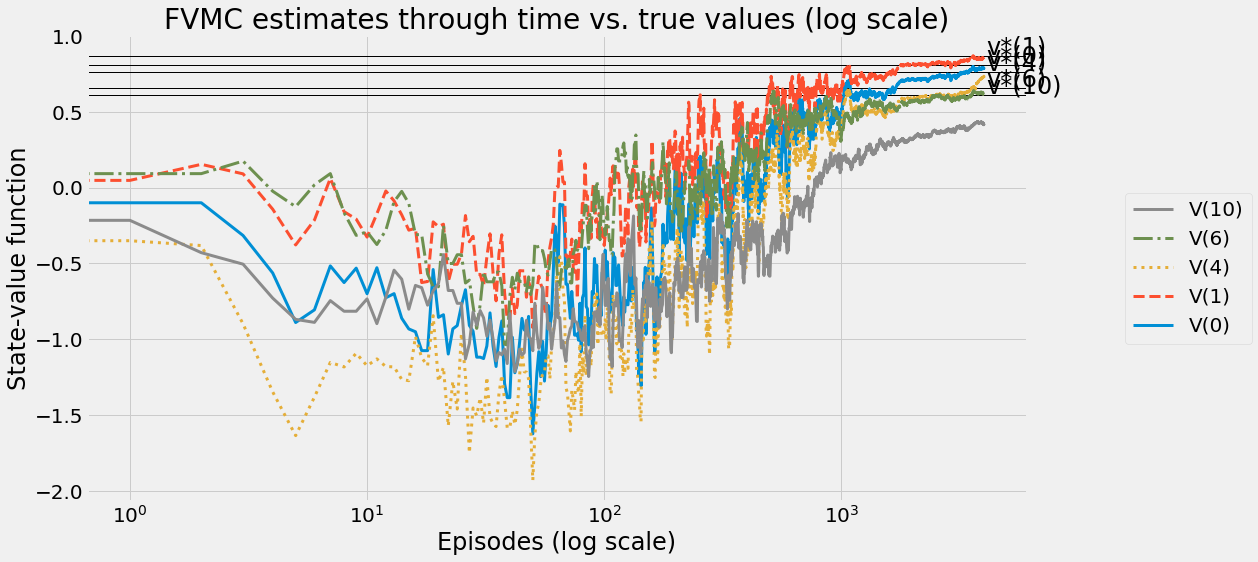

In [60]:
plot_value_function(
    'FVMC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.01,
    log=True)

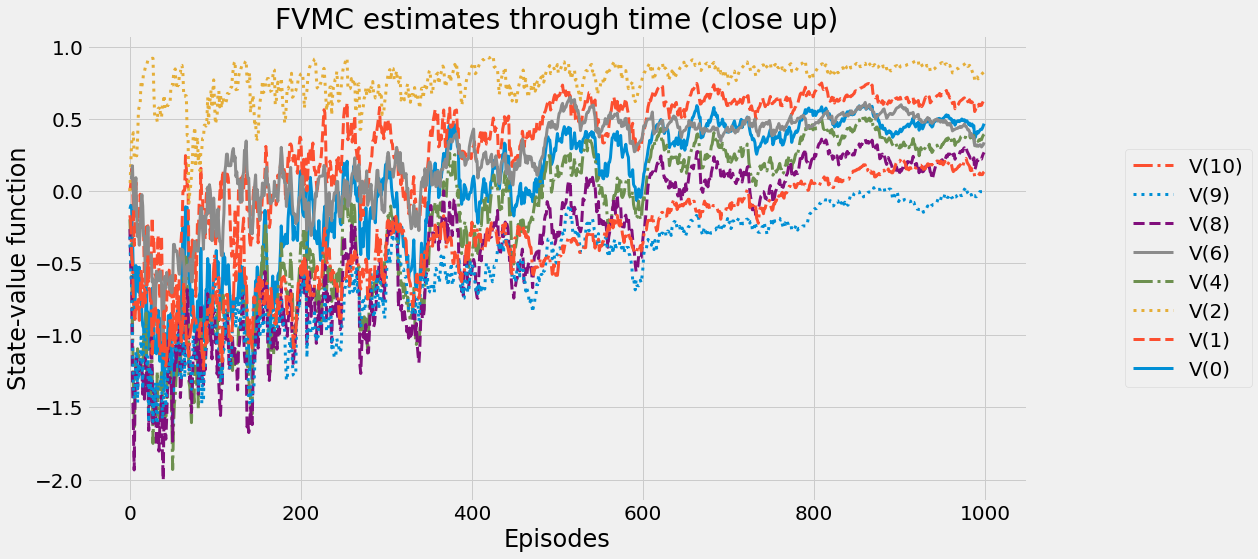

In [61]:
plot_value_function(
    'FVMC estimates through time (close up)', 
    np.max(Q_track_mc, axis=2)[:1000], 
    None,
    limit_items=10,
    limit_value=0.0,
    log=False)

## SARSA

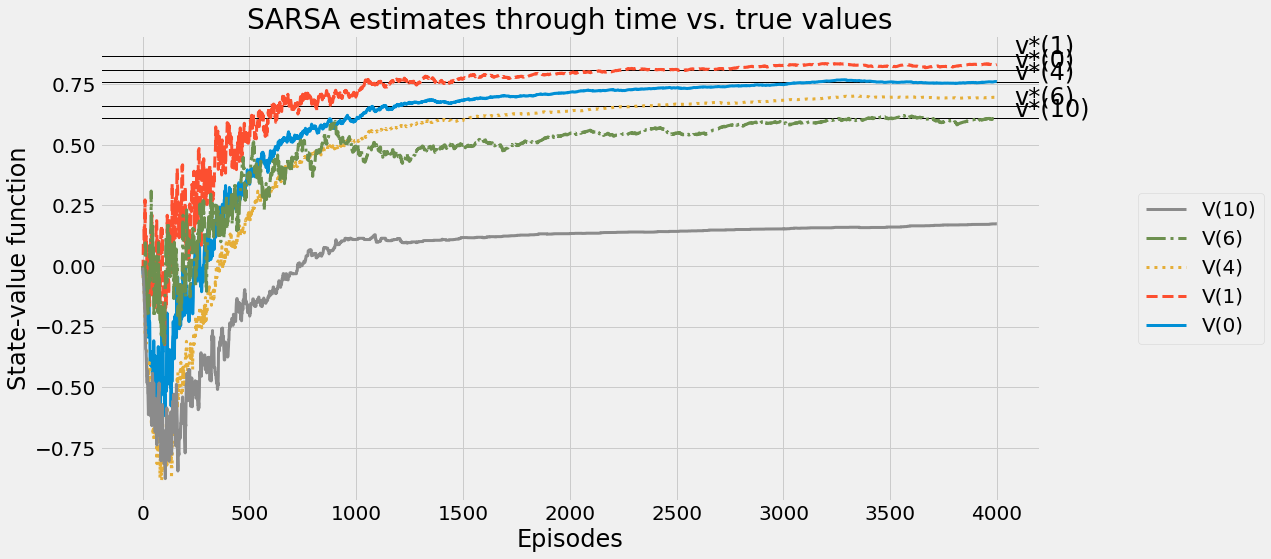

In [62]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.01,
    log=False)

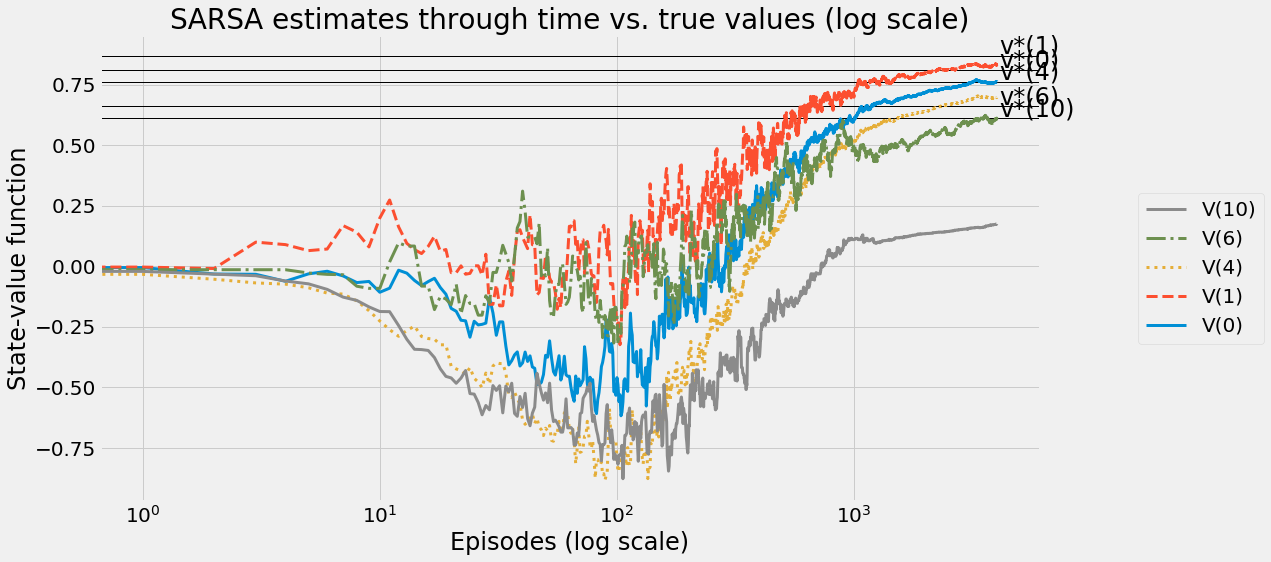

In [63]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.01,
    log=True)

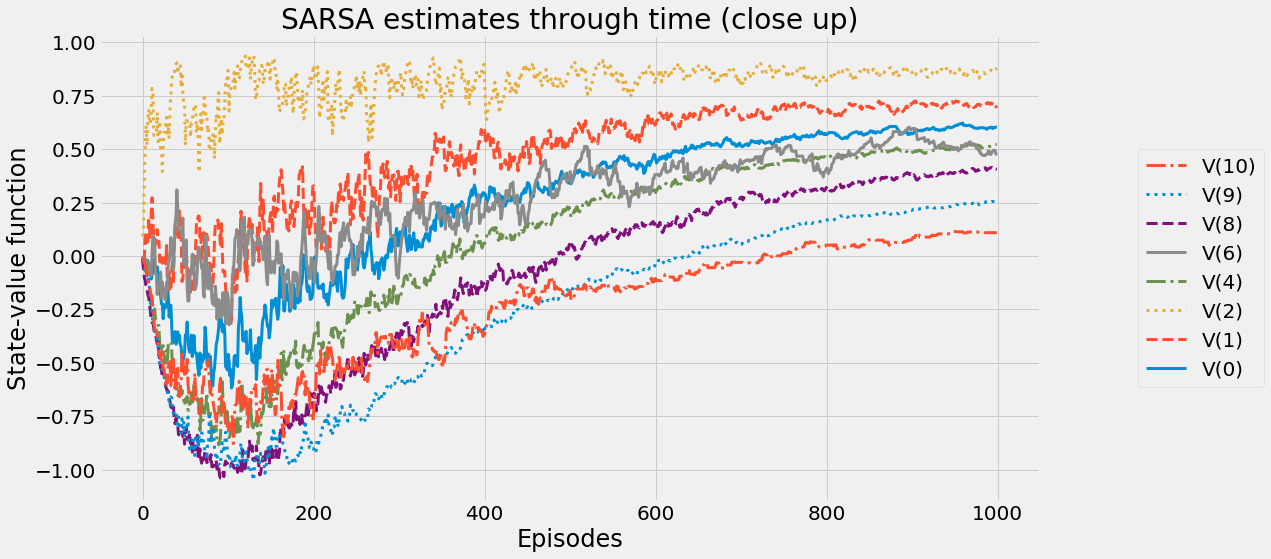

In [64]:
plot_value_function(
    'SARSA estimates through time (close up)', 
    np.max(Q_track_sarsa, axis=2)[:1000], 
    None,
    limit_items=10,
    limit_value=0.0,
    log=False)

## Q-learning

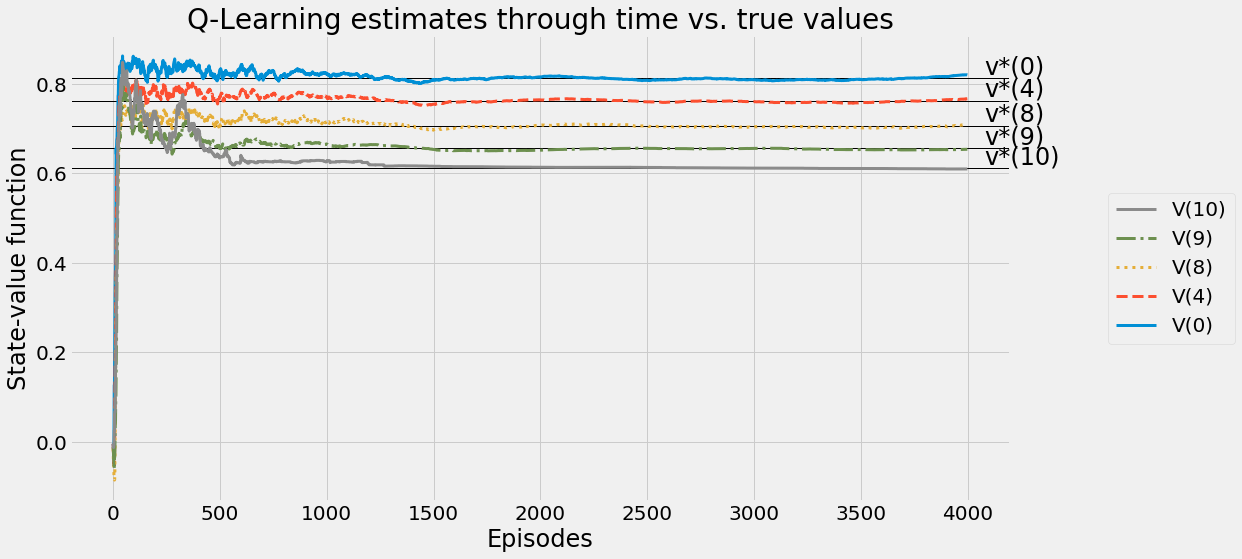

In [65]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.01,
    log=False)

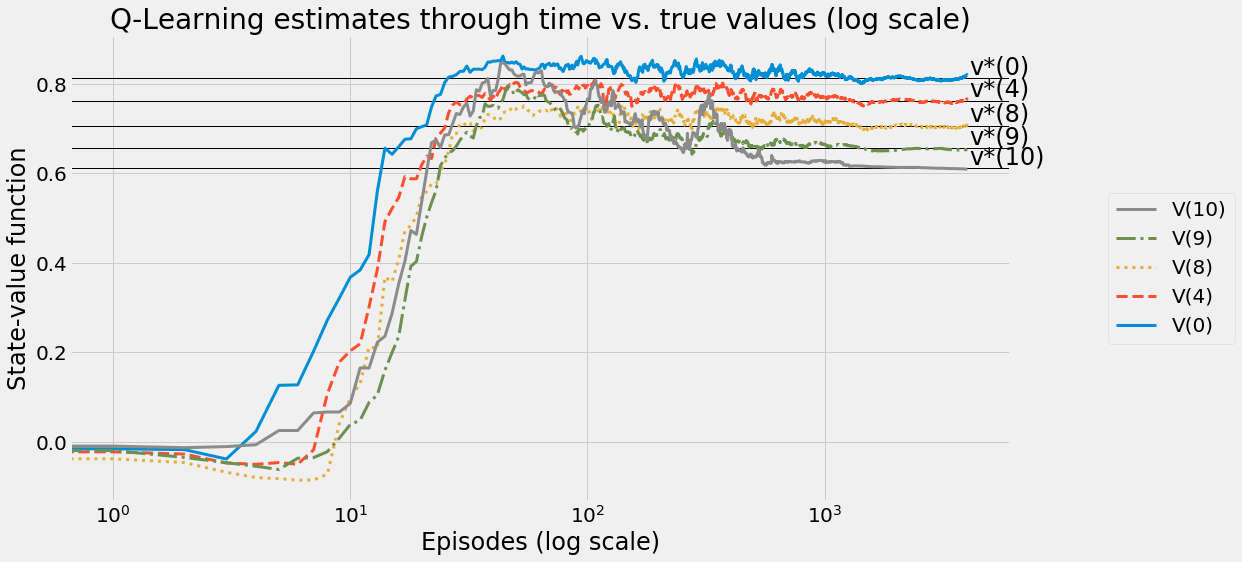

In [66]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.01,
    log=True)

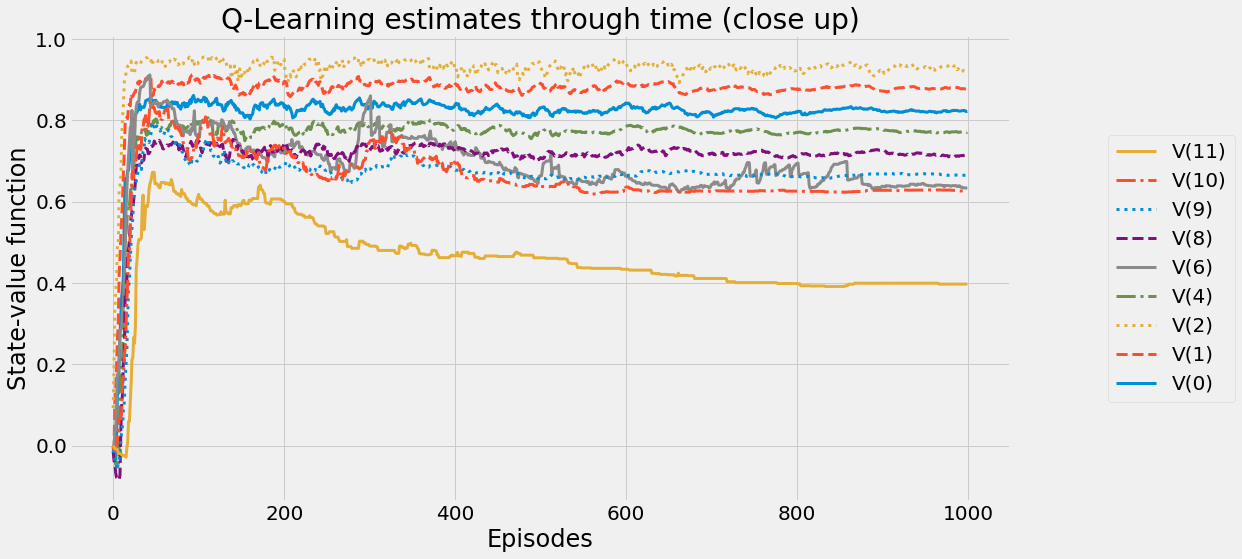

In [67]:
plot_value_function(
    'Q-Learning estimates through time (close up)', 
    np.max(Q_track_ql, axis=2)[:1000], 
    None,
    limit_items=10,
    limit_value=0.0,
    log=False)

## Double Q-Learning

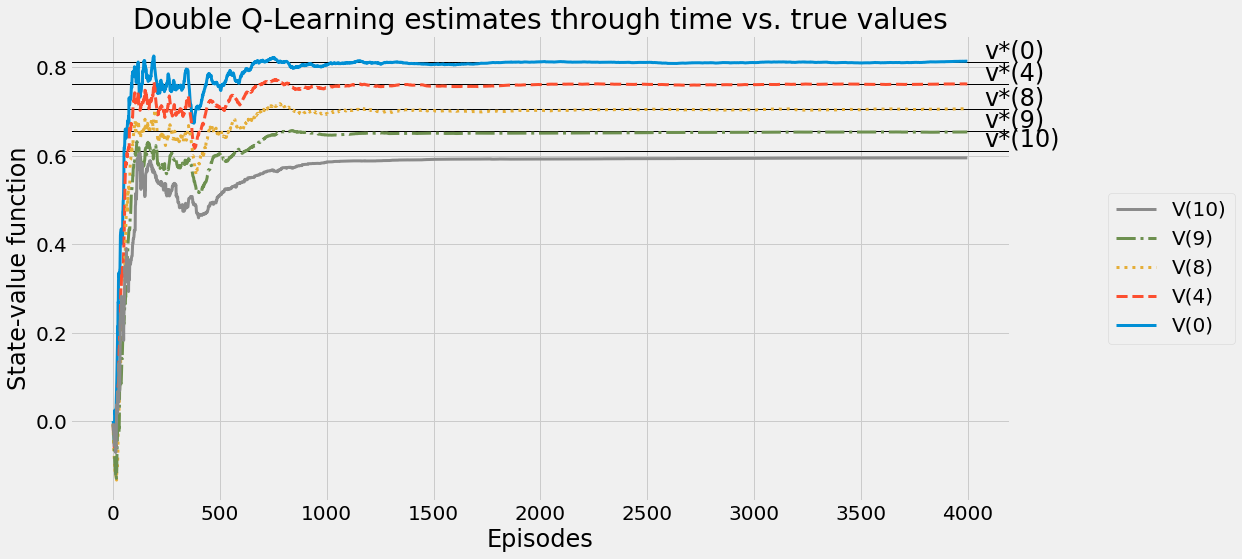

In [68]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.01,
    log=False)

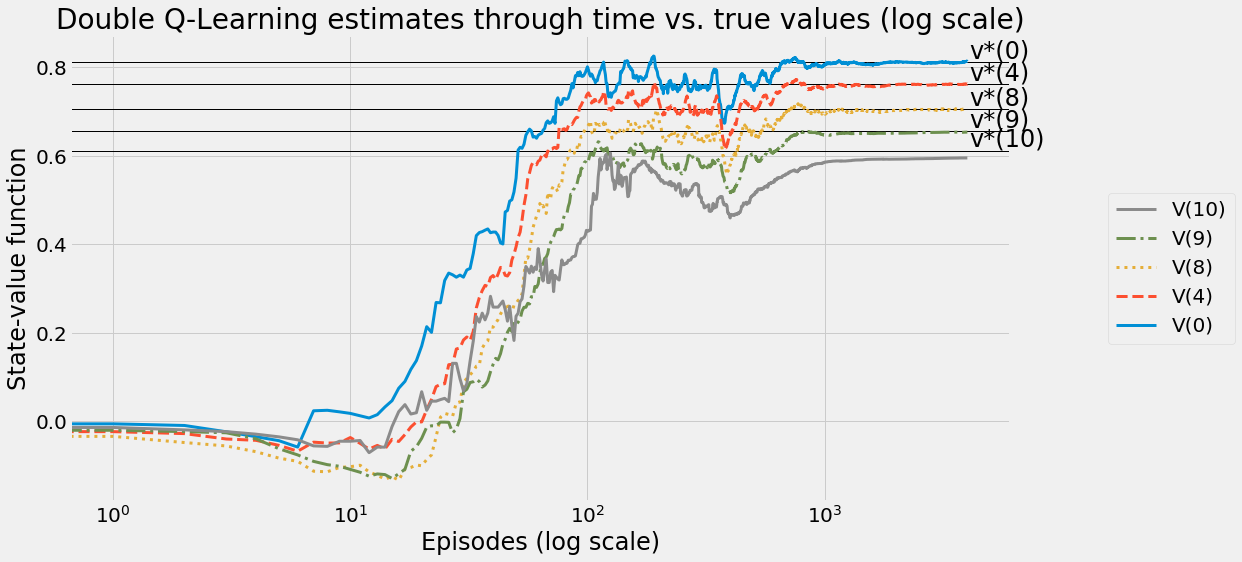

In [69]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.01,
    log=True)

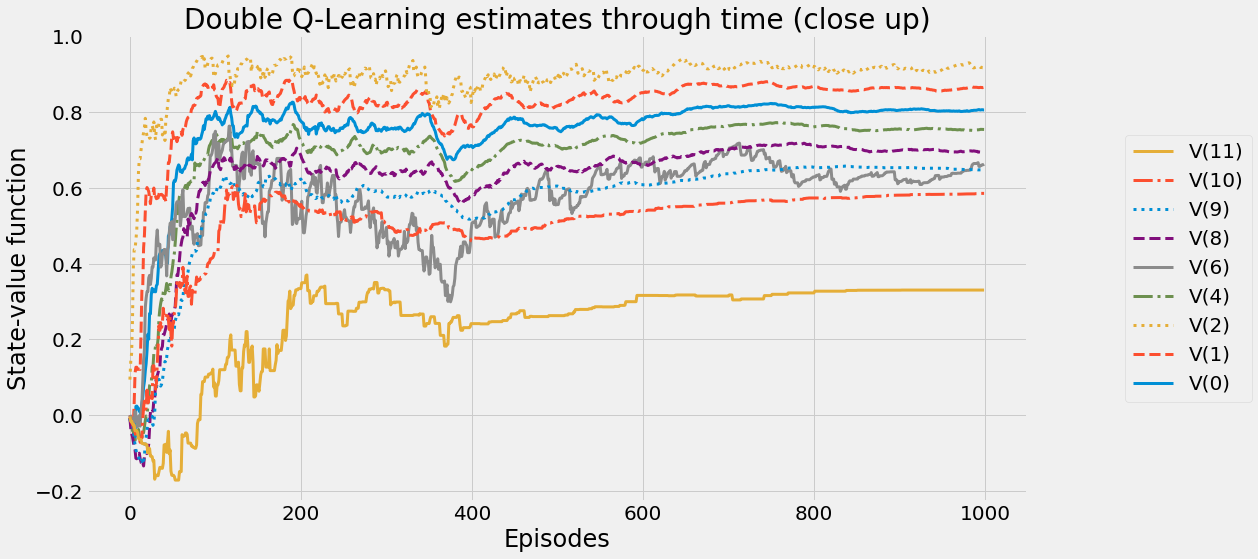

In [70]:
plot_value_function(
    'Double Q-Learning estimates through time (close up)', 
    np.max(Q_track_dql, axis=2)[:1000], 
    None,
    limit_items=10,
    limit_value=0.0,
    log=False)

# Policy evolution comparison

In [71]:
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_mc)])).T

In [72]:
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_sarsa)])).T

In [73]:
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_ql)])).T

In [74]:
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_dql)])).T

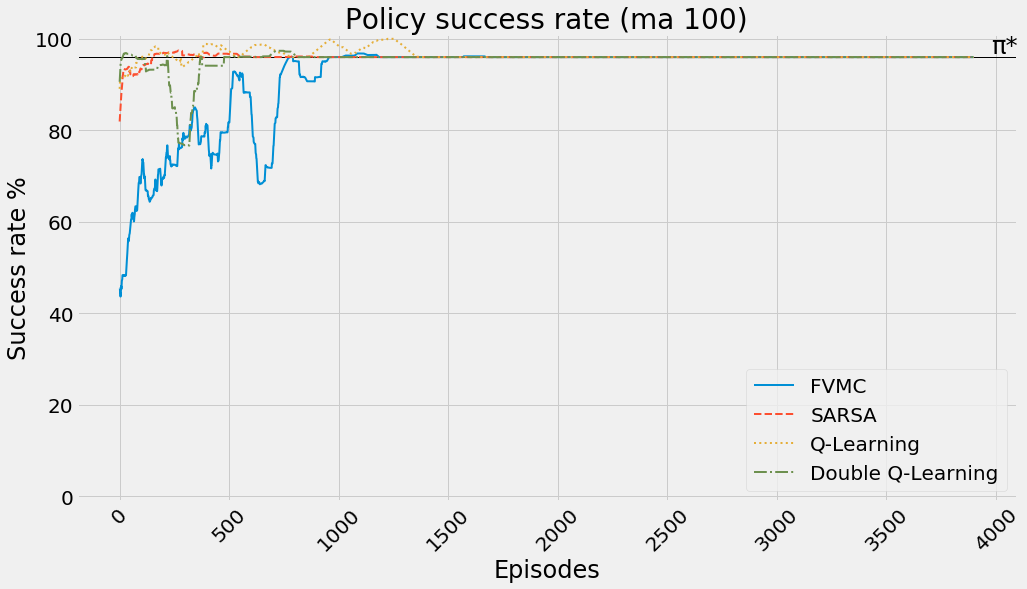

In [75]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

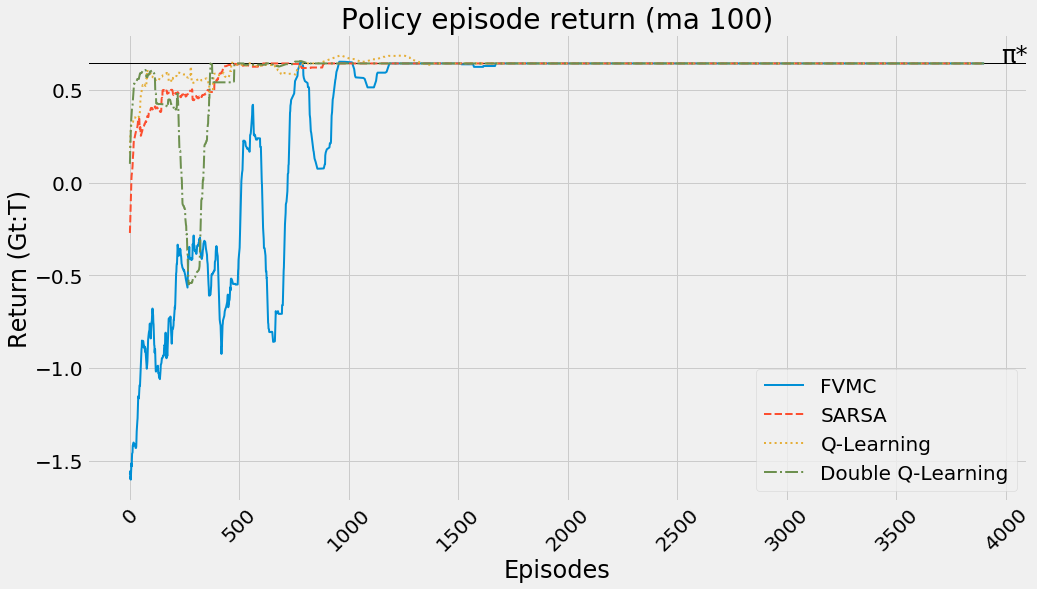

In [76]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

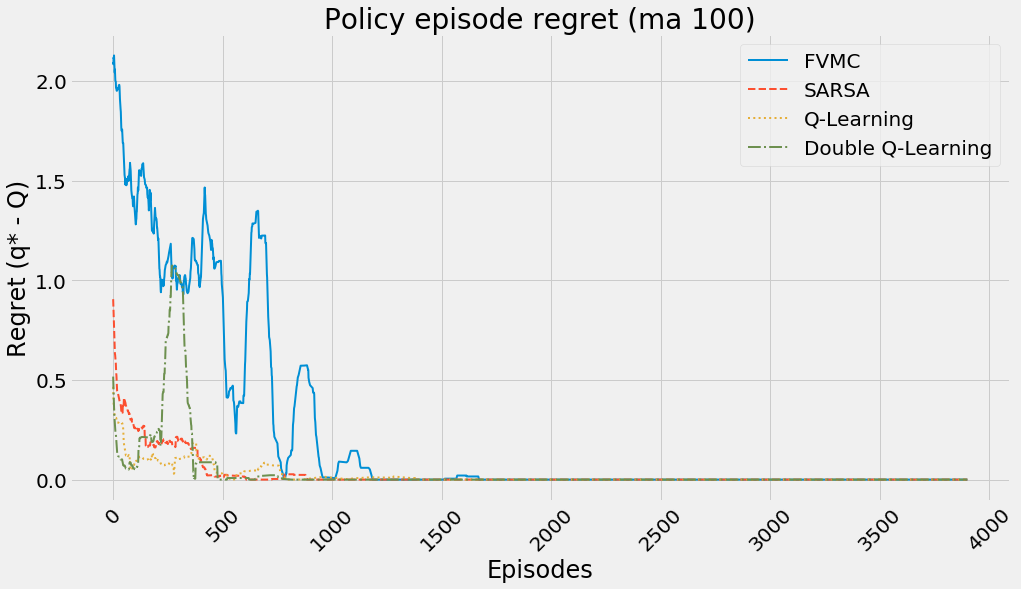

In [77]:
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

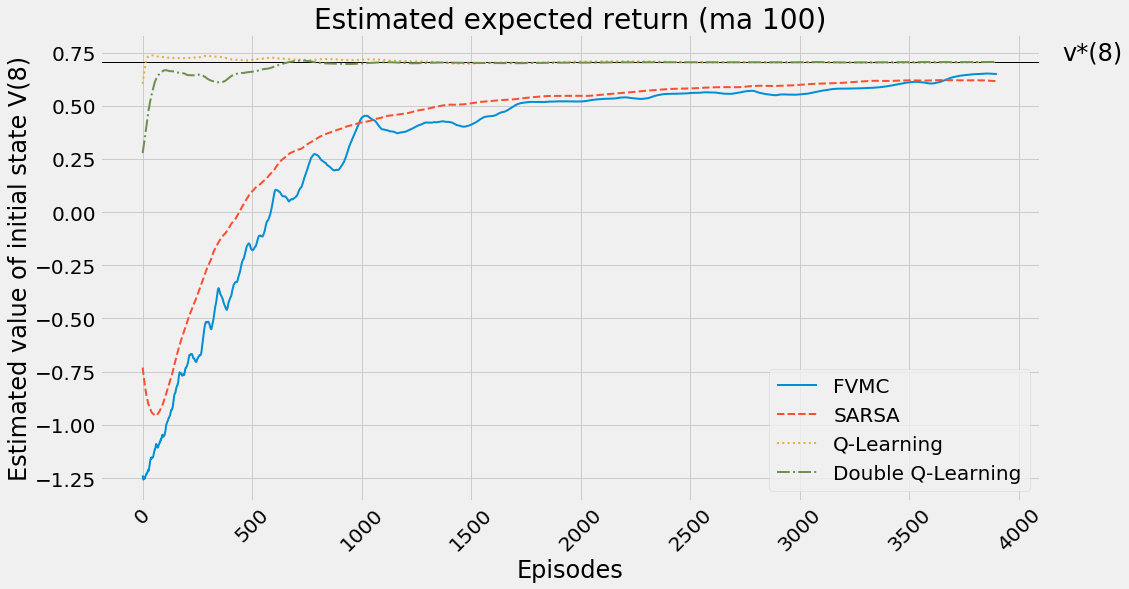

In [78]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

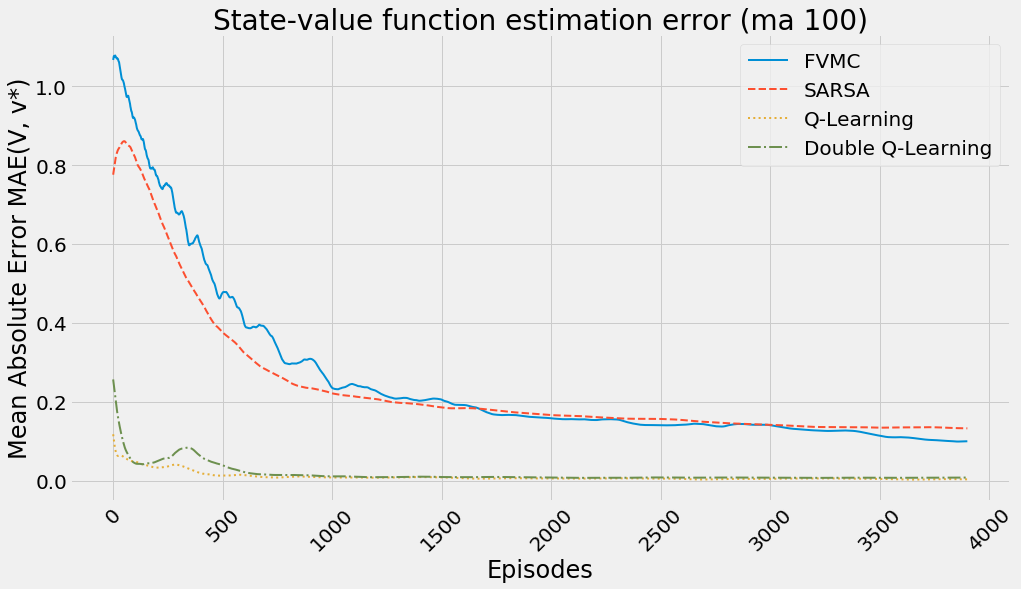

In [79]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

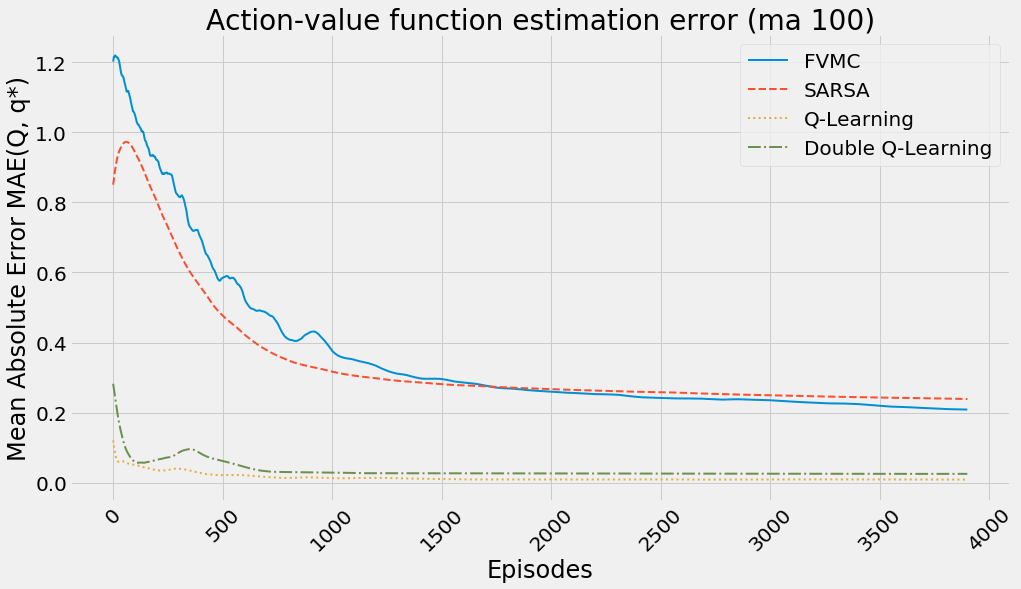

In [80]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()

# FrozenLake environment

In [81]:
env = gym.make('FrozenLake-v0')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 10000
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.542  │ 0.5278 │ 0.5278 │ 0.5223 │
├─────┼────────┼────────┼────────┼────────┤
│   1 │ 0.3435 │ 0.3342 │ 0.3199 │ 0.4988 │
├─────┼────────┼────────┼────────┼────────┤
│   2 │ 0.4382 │ 0.4336 │ 0.4243 │ 0.4707 │
├─────┼────────┼────────┼────────┼────────┤
│   3 │ 0.3061 │ 0.3061 │ 0.3015 │ 0.4569 │
├─────┼────────┼────────┼────────┼────────┤
│   4 │ 0.5585 │ 0.3796 │ 0.3742 │ 0.3632 │
├─────┼────────┼────────┼────────┼────────┤
│   5 │ 0      │ 0      │ 0      │ 0      │
├─────┼────────┼────────┼────────┼────────┤
│   6 │ 0.3583 │ 0.203  │ 0.3583 │ 0.1553 │
├─────┼────────┼────────┼────────┼

In [82]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

In [83]:
print_state_value_function(V_mc, P, n_cols=4, prec=3, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
| 00   0.29 | 01  0.217 | 02  0.197 | 03   0.09 |
| 04  0.313 |           | 06   0.21 |           |
| 08  0.361 | 09  0.446 | 10  0.451 |           |
|           | 13  0.575 | 14  0.787 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.252 | 01 -0.281 | 02 -0.273 | 03 -0.366 |
| 04 -0.245 |           | 06 -0.148 |           |
| 08 -0.231 | 09 -0.197 | 10 -0.165 |           |
|           | 13 -0.167 | 14 -0.076 |           |
State-value function RMSE: 0.1914

FVMC action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═════

In [84]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    Q_sarsas.append(Q_sarsa) ; V_sarsas.append(V_sarsa) ; Q_track_sarsas.append(Q_track_sarsa)
Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)
del Q_sarsas ; del V_sarsas ; del Q_track_sarsas

In [85]:
print_state_value_function(V_sarsa, P, n_cols=4, prec=3, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

State-value function found by SARSA:
| 00  0.281 | 01  0.226 | 02    0.2 | 03  0.114 |
| 04  0.301 |           | 06  0.214 |           |
| 08  0.354 | 09  0.449 | 10  0.458 |           |
|           | 13  0.582 | 14   0.76 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.261 | 01 -0.273 | 02  -0.27 | 03 -0.343 |
| 04 -0.257 |           | 06 -0.145 |           |
| 08 -0.238 | 09 -0.194 | 10 -0.157 |           |
|           | 13  -0.16 | 14 -0.103 |           |
State-value function RMSE: 0.1897

SARSA action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═══

In [86]:
Q_qls, V_qls, Q_track_qls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_qls.append(Q_ql) ; V_qls.append(V_ql) ; Q_track_qls.append(Q_track_ql)
Q_ql = np.mean(Q_qls, axis=0)
V_ql = np.mean(V_qls, axis=0)
Q_track_ql = np.mean(Q_track_qls, axis=0)
del Q_qls ; del V_qls ; del Q_track_qls

In [87]:
print_state_value_function(V_ql, P, n_cols=4, prec=3, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_ql, mean_return_ql, mean_regret_ql = get_policy_metrics(
    env, gamma=gamma, pi=pi_ql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_ql, mean_return_ql, mean_regret_ql))

State-value function found by Q-learning:
| 00  0.518 | 01  0.475 | 02  0.445 | 03   0.43 |
| 04  0.537 |           | 06  0.348 |           |
| 08  0.573 | 09  0.626 | 10  0.603 |           |
|           | 13  0.733 | 14  0.861 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.025 | 01 -0.024 | 02 -0.026 | 03 -0.027 |
| 04 -0.022 |           | 06  -0.01 |           |
| 08 -0.019 | 09 -0.017 | 10 -0.012 |           |
|           | 13 -0.009 | 14 -0.002 |           |
State-value function RMSE: 0.0159

Q-learning action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪

In [88]:
Q_dqls, V_dqls, Q_track_dqls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=gamma, n_episodes=n_episodes)
    Q_dqls.append(Q_dql) ; V_dqls.append(V_dql) ; Q_track_dqls.append(Q_track_dql)
Q_dql, V_dql, Q_track_dql = np.mean(Q_dqls, axis=0), np.mean(V_dqls, axis=0), np.mean(Q_track_dqls, axis=0)
del Q_dqls ; del V_dqls ; del Q_track_dqls

In [89]:
print_state_value_function(V_dql, P, n_cols=4, prec=3, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_dql, mean_return_dql, mean_regret_dql = get_policy_metrics(
    env, gamma=gamma, pi=pi_dql, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dql, mean_return_dql, mean_regret_dql))

State-value function found by Double Q-Learning:
| 00  0.518 | 01  0.444 | 02  0.378 | 03   0.28 |
| 04  0.535 |           | 06   0.31 |           |
| 08   0.57 | 09  0.619 | 10  0.586 |           |
|           | 13  0.724 | 14   0.85 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.024 | 01 -0.055 | 02 -0.092 | 03 -0.176 |
| 04 -0.024 |           | 06 -0.048 |           |
| 08 -0.022 | 09 -0.024 | 10  -0.03 |           |
|           | 13 -0.018 | 14 -0.013 |           |
State-value function RMSE: 0.0551

Double Q-Learning action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │


# Comparison of max(Q) for every episode

## Monte-Carlo

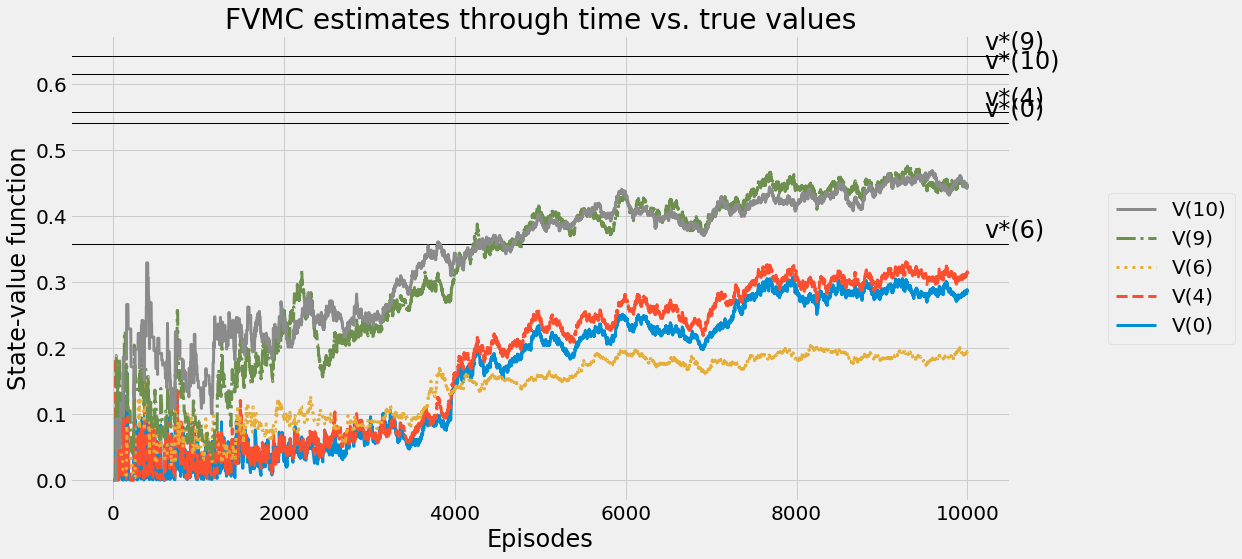

In [90]:
plot_value_function(
    'FVMC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2),
    optimal_V,
    limit_items=5,
    log=False)

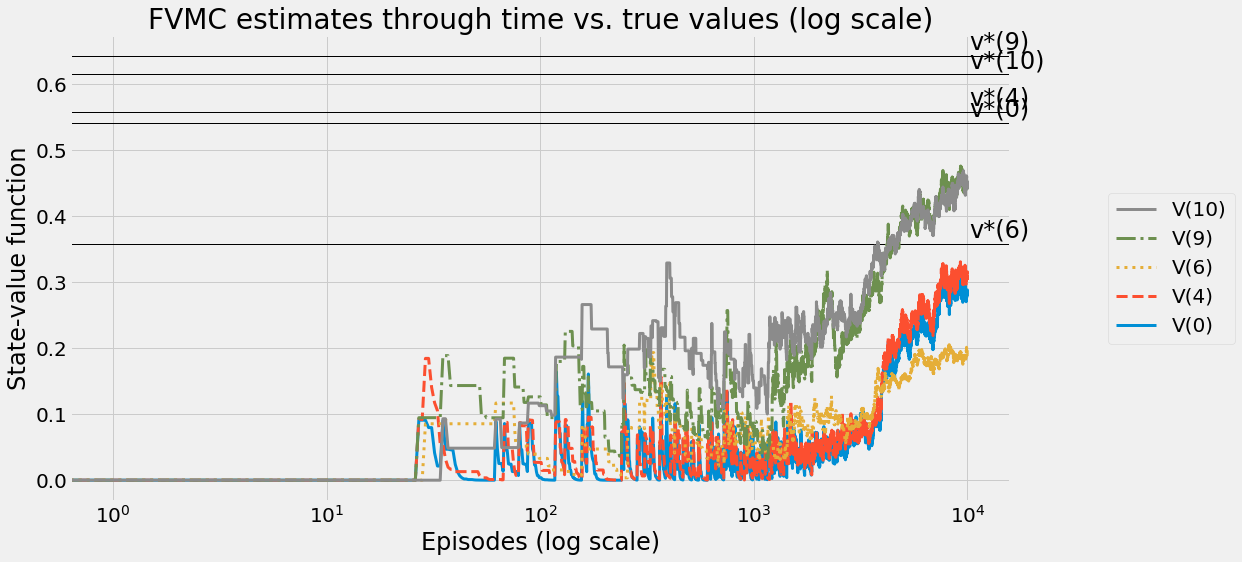

In [91]:
plot_value_function(
    'FVMC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

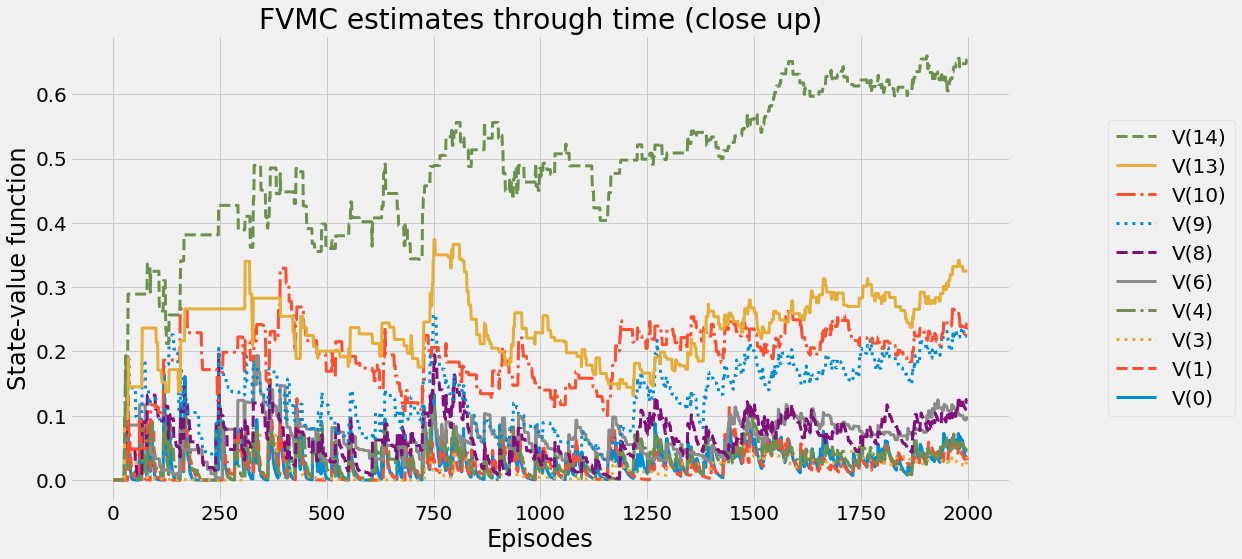

In [92]:
plot_value_function(
    'FVMC estimates through time (close up)', 
    np.max(Q_track_mc, axis=2)[:2000], 
    None,
    limit_items=10,
    limit_value=0.01,
    log=False)

## SARSA

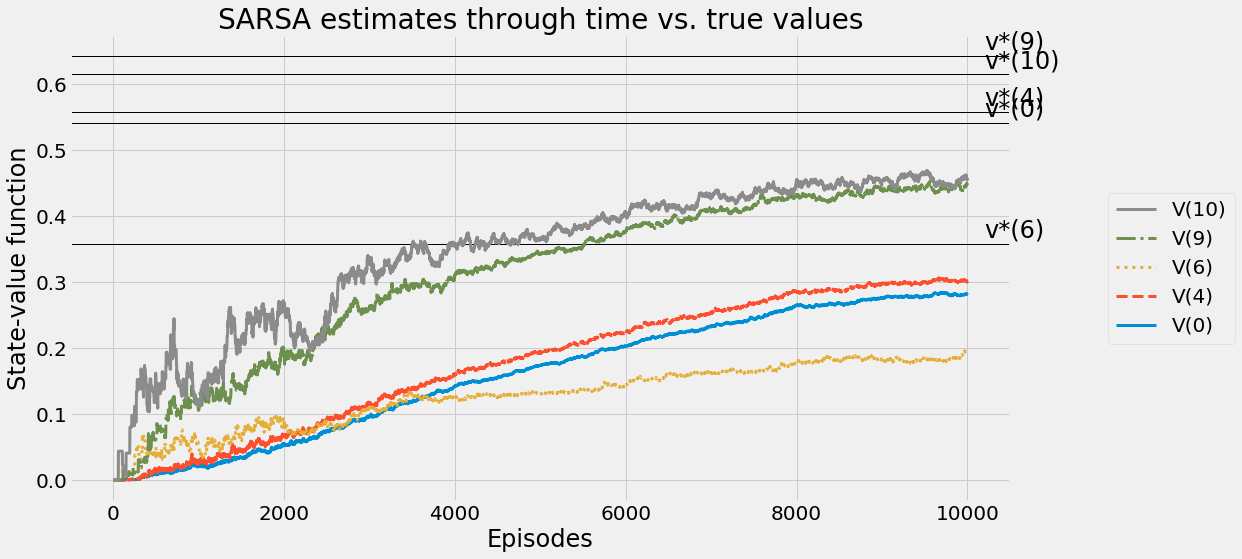

In [93]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

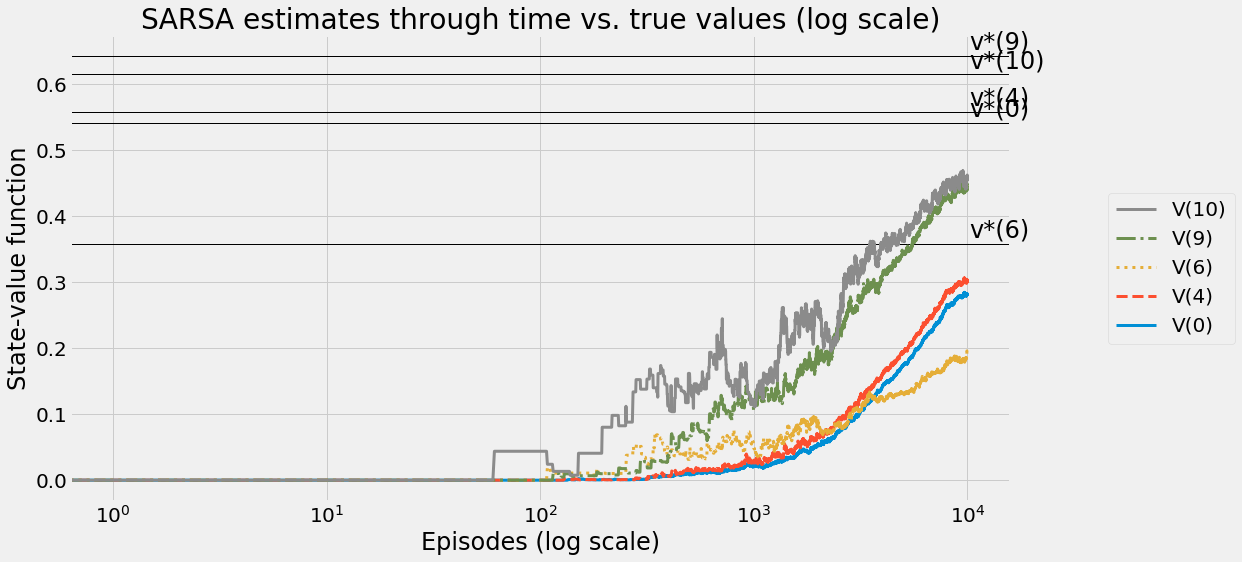

In [94]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

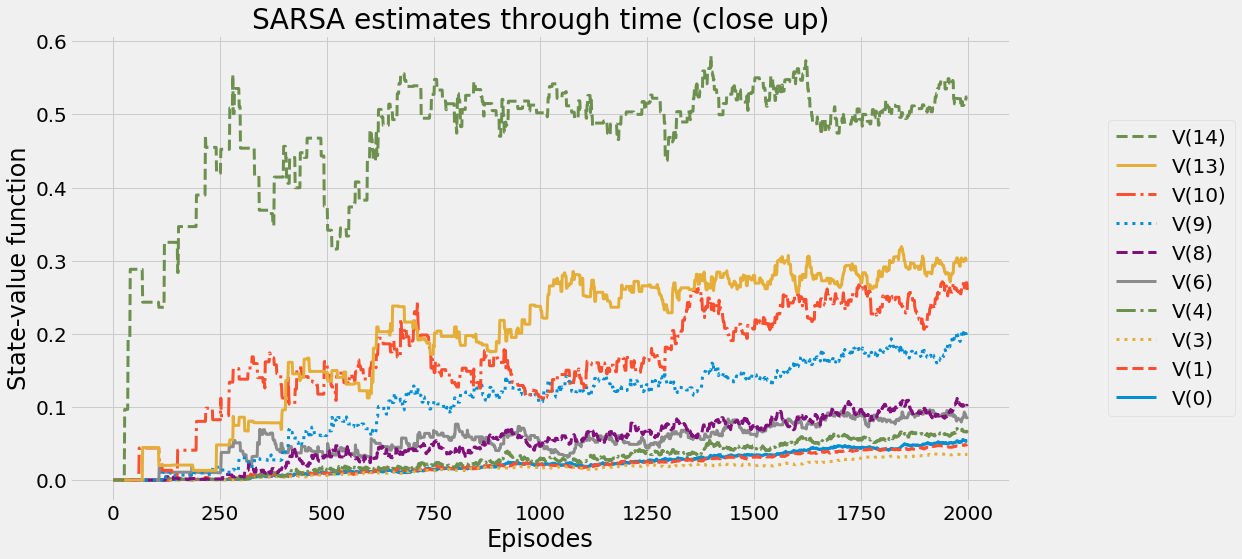

In [95]:
plot_value_function(
    'SARSA estimates through time (close up)', 
    np.max(Q_track_sarsa, axis=2)[:2000], 
    None,
    limit_items=10,
    limit_value=0.01,
    log=False)

## Q-learning

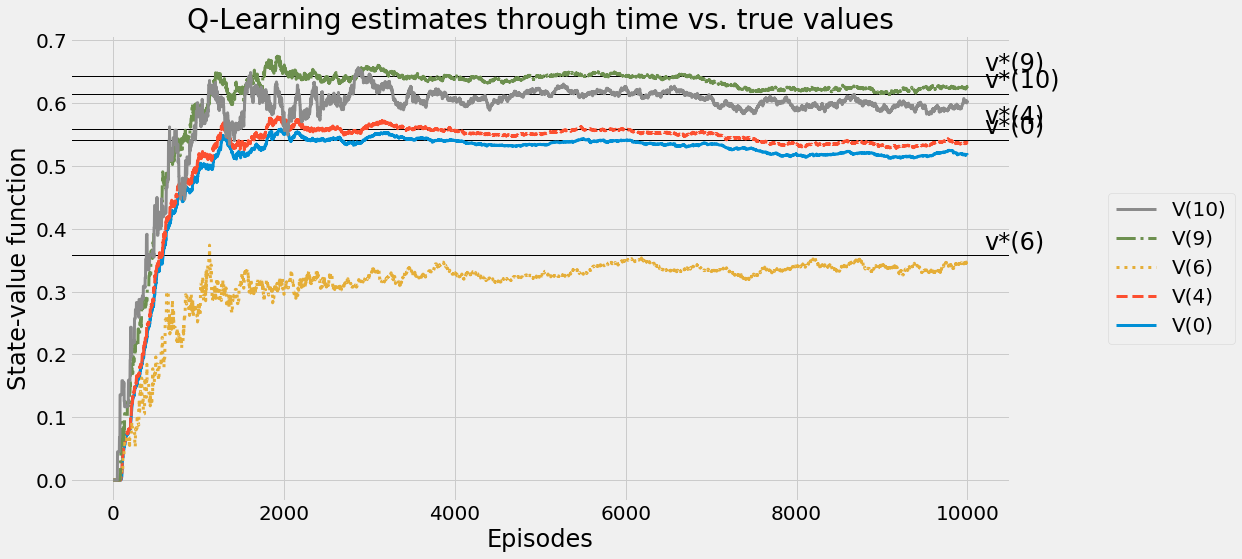

In [96]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

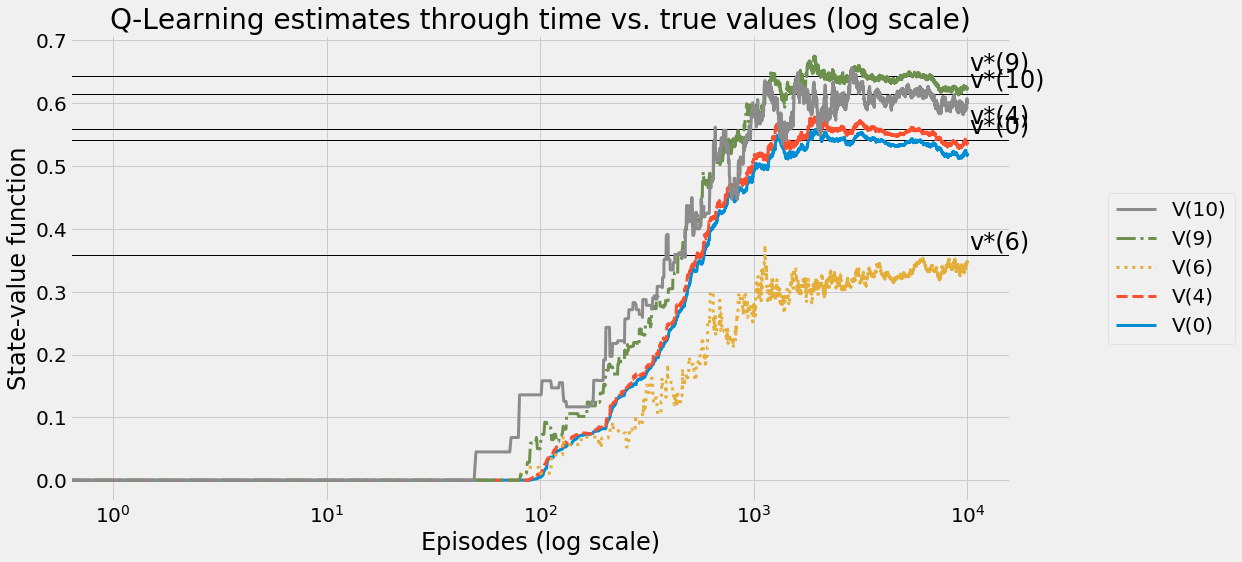

In [97]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

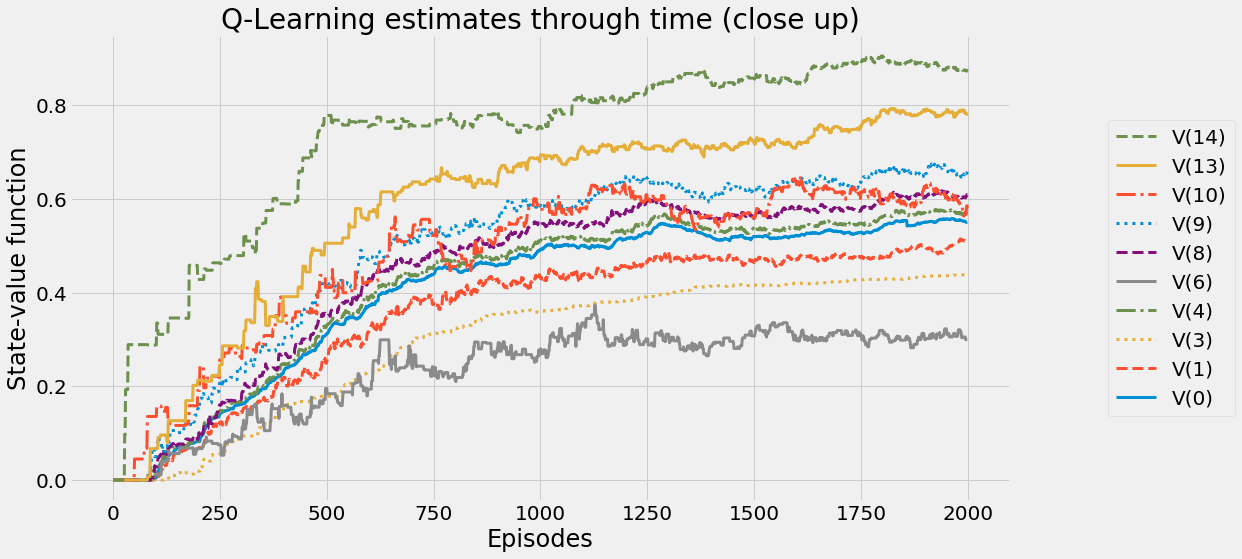

In [98]:
plot_value_function(
    'Q-Learning estimates through time (close up)', 
    np.max(Q_track_ql, axis=2)[:2000], 
    None,
    limit_items=10,
    limit_value=0.01,
    log=False)

## Double Q-Learning

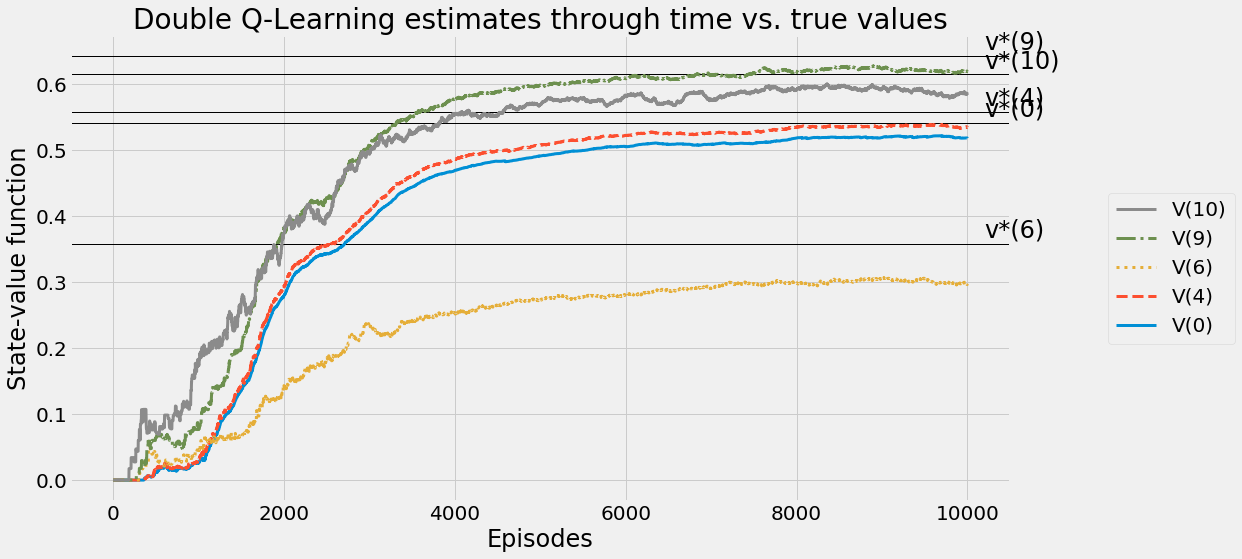

In [99]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=5,
    log=False)

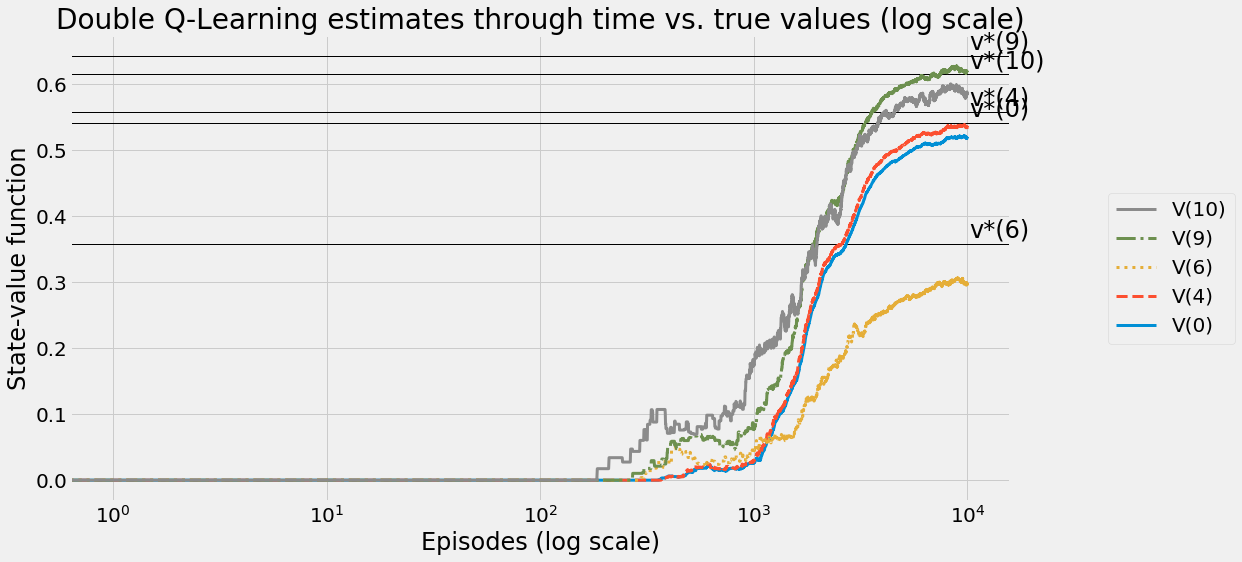

In [100]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V,
    limit_items=5,
    log=True)

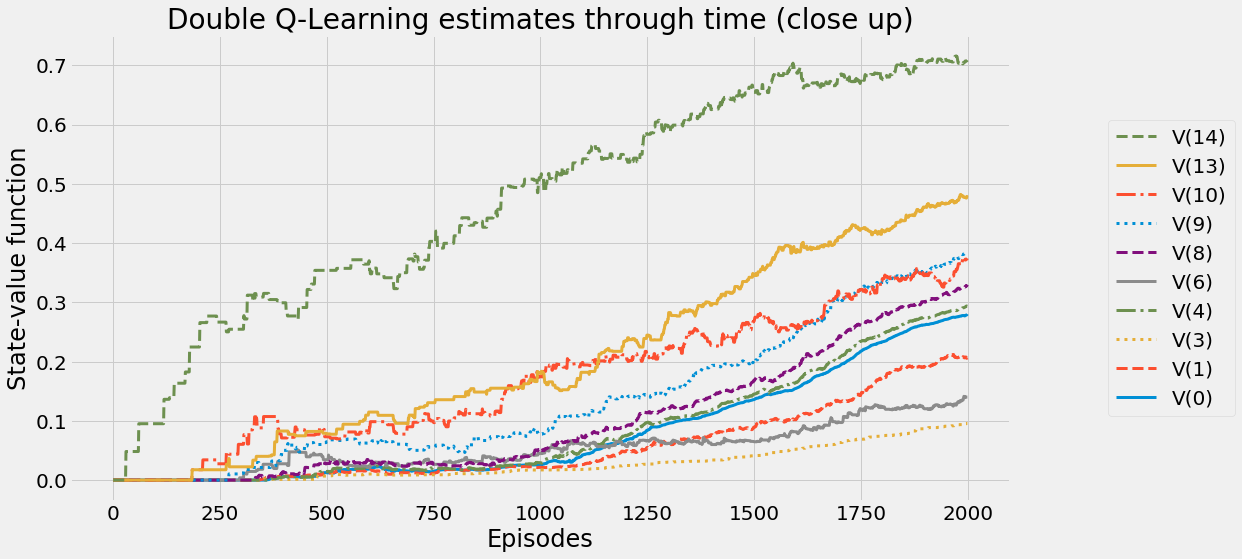

In [101]:
plot_value_function(
    'Double Q-Learning estimates through time (close up)', 
    np.max(Q_track_dql, axis=2)[:2000], 
    None,
    limit_items=10,
    limit_value=0.01,
    log=False)

# Policy evolution comparison

In [102]:
mc_success_rate_ma, mc_mean_return_ma, mc_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_mc)])).T

In [103]:
sarsa_success_rate_ma, sarsa_mean_return_ma, sarsa_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_sarsa)])).T

In [104]:
ql_success_rate_ma, ql_mean_return_ma, ql_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_ql)])).T

In [105]:
dql_success_rate_ma, dql_mean_return_ma, dql_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            gamma=gamma, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_dql)])).T

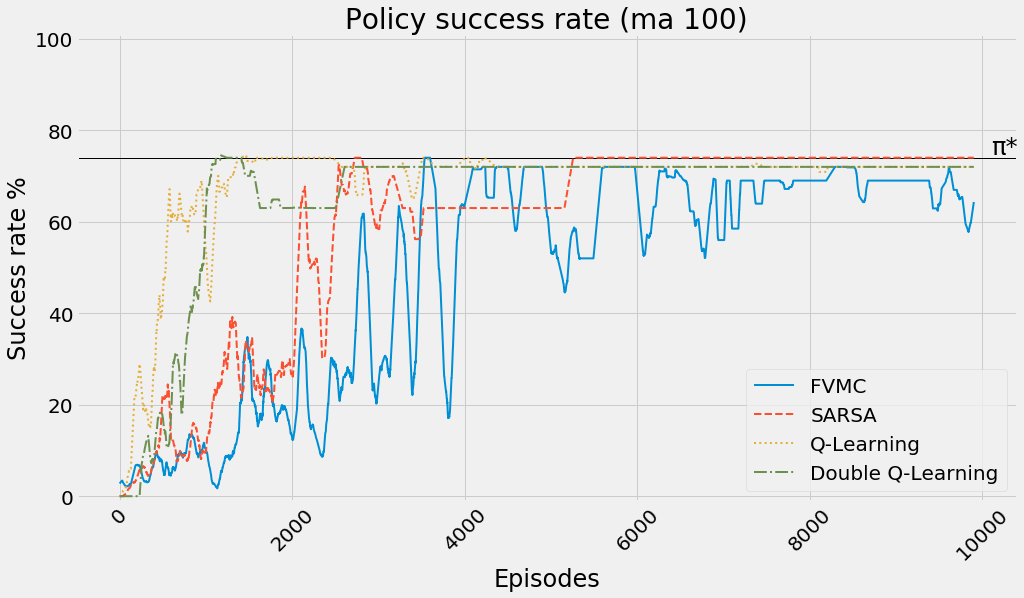

In [106]:
plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.plot(mc_success_rate_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_success_rate_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_rate_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_success_rate_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

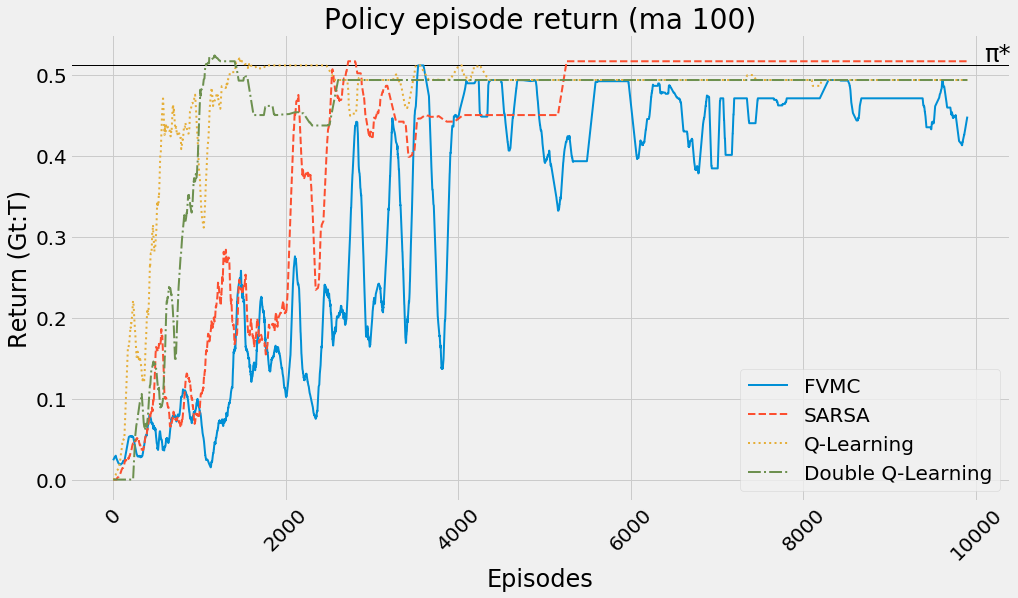

In [107]:
plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(mc_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.plot(mc_mean_return_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_return_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_return_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_return_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Policy episode return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return (Gt:T)')

plt.xticks(rotation=45)

plt.show()

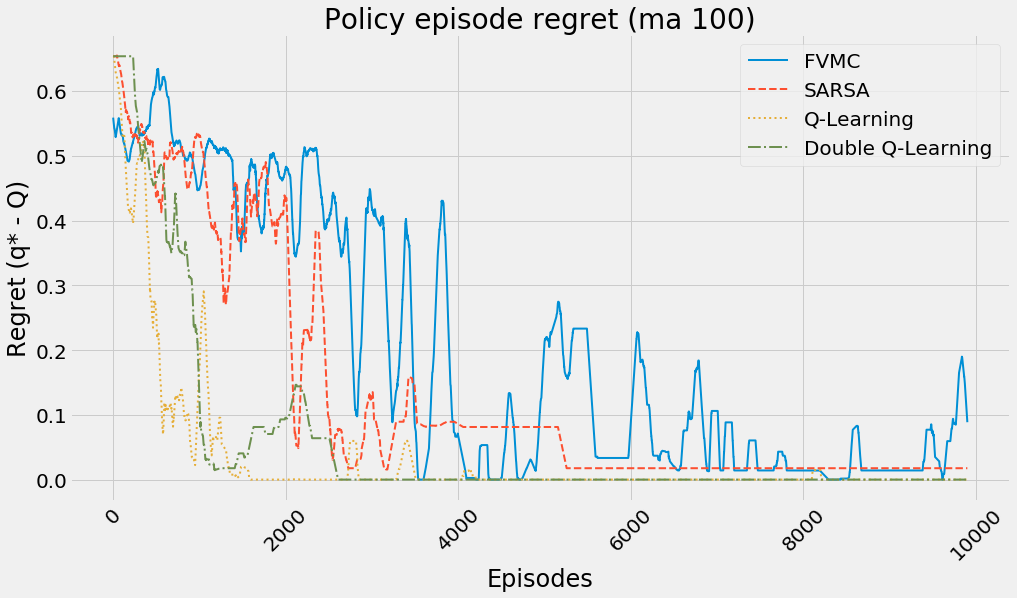

In [108]:
plt.plot(mc_mean_regret_ma, '-', linewidth=2, label='FVMC')
plt.plot(sarsa_mean_regret_ma, '--', linewidth=2, label='SARSA')
plt.plot(ql_mean_regret_ma, ':', linewidth=2, label='Q-Learning')
plt.plot(dql_mean_regret_ma, '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Policy episode regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Regret (q* - Q)')
plt.xticks(rotation=45)

plt.show()

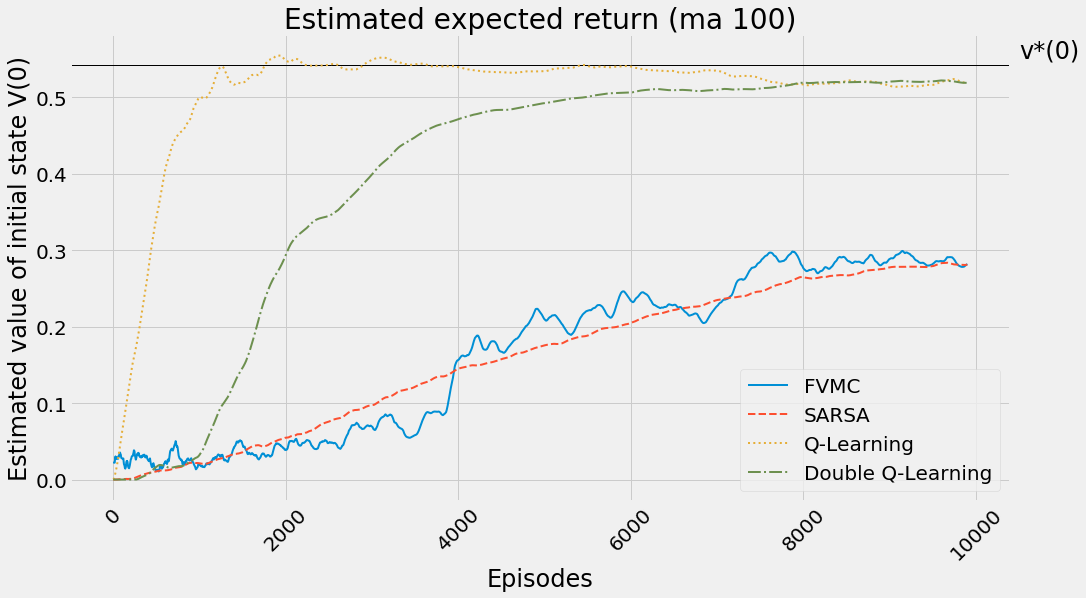

In [109]:
plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[init_state]+.01, 'v*({})'.format(init_state))

plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[init_state]), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[init_state]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[init_state]), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[init_state]), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=4, ncol=1)

plt.title('Estimated expected return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state V({})'.format(init_state))
plt.xticks(rotation=45)

plt.show()

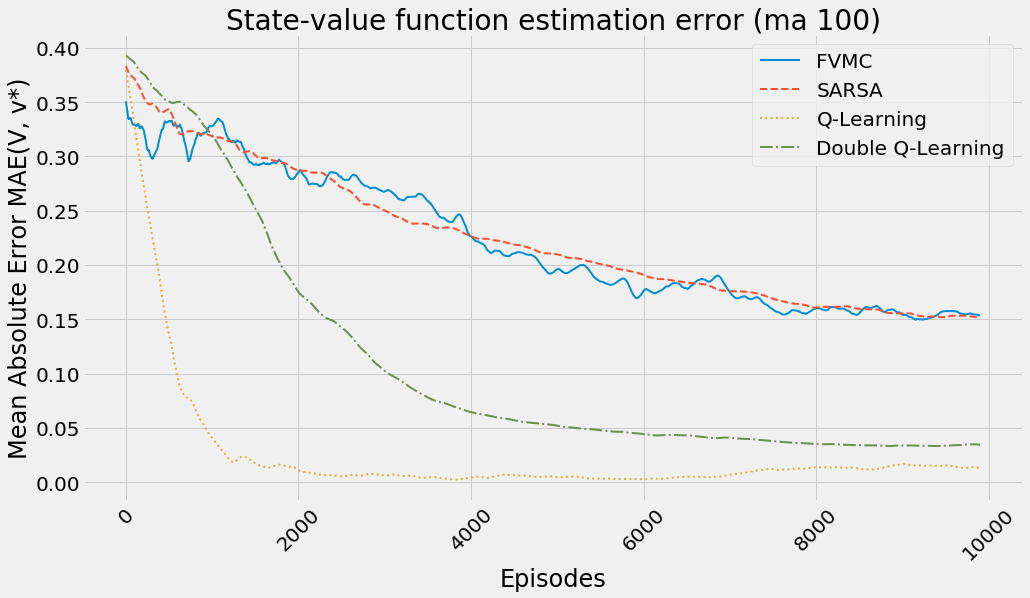

In [110]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')
plt.xticks(rotation=45)

plt.show()

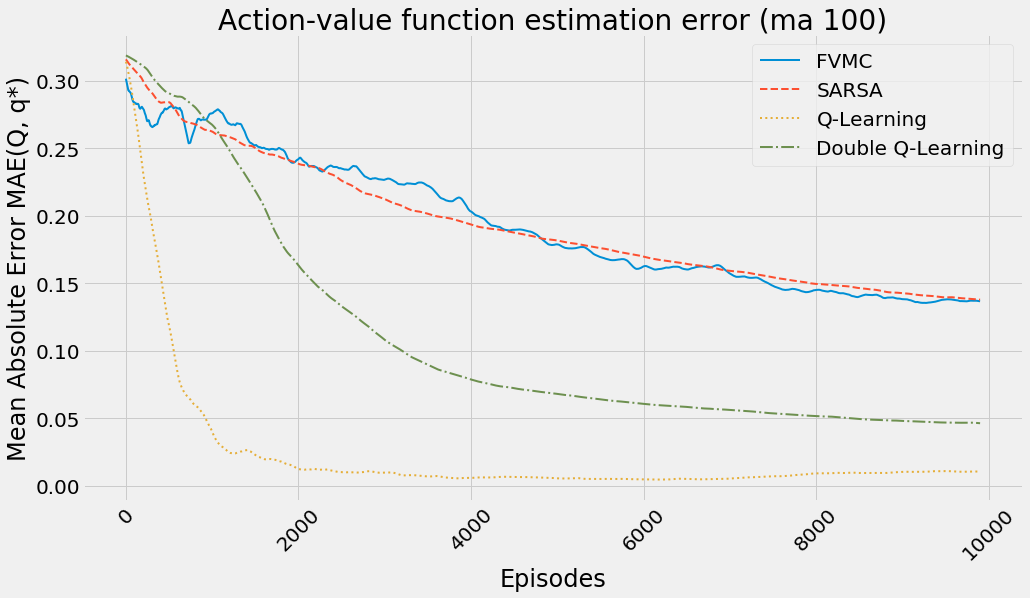

In [111]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='FVMC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-.', linewidth=2, label='Double Q-Learning')
plt.legend(loc=1, ncol=1)

plt.title('Action-value function estimation error (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(Q, q*)')
plt.xticks(rotation=45)

plt.show()